# **INITIALISATION**

## Python Environment

### Import Python libraries

In [1]:
# Data libraries
import os
import pandas as pd
import calendar
import numpy as np
import gc
import math
from operator import itemgetter
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from seaborn import violinplot, boxenplot

# Model training
from sklearn.model_selection import cross_validate
from sklearn import metrics, preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
#from imblearn.ensemble import RUSBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import base
import joblib
    # Keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Lambda
    # Tensorflow
import tensorflow as tf

# Statistical tests
from scipy.stats import shapiro

### SET ENVIRONMENT VARIABLES

In [2]:
# WORKING FOLDER: /content/local/Traffic/data or /content/drive/MyDrive/Traffic/data
ROOT = '/content/local/Traffic/data'
# PREDICTION HORIZON
PREDICTED_MINUTES_AHEAD = 5
if (PREDICTED_MINUTES_AHEAD%5 != 0): raise ValueError("Invalid prediction horizon. Must be multiple of 5 minutes")
INPUT_MINUTES_BEFORE = 45
if (INPUT_MINUTES_BEFORE%5 != 0): raise ValueError("Invalid input minutes span. Must be multiple of 5 minutes")

## Files (Ignore if working locally)

### Mount \<Google Drive\>

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf sample_data

Mounted at /content/drive


### Clone \<Github\>

In [ ]:
!sh /content/drive/MyDrive/Traffic/scripts/initialisation.sh

/content/drive/MyDrive/Traffic/scripts/initialisation.sh: 1: %cd: not found
Cloning into 'Traffic'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 104 (delta 42), reused 36 (delta 3), pack-reused 0
Receiving objects: 100% (104/104), 9.85 MiB | 17.27 MiB/s, done.
Resolving deltas: 100% (42/42), done.
/content/drive/MyDrive/Traffic/scripts/initialisation.sh: 3: %cd: not found


In [ ]:
%cd /content/Traffic
!git config user.email diego@google.colab.com
!git config user.name "Google Colab"
!git config http.postBuffer 524288000

/content/Traffic


# **UPLOAD DATA**

## TO GOOGLE DRIVE [ LINK_ID, TT_ARR, LOS_DEP ]

In [ ]:


training = []
validation = []
total_size = 0

directory = '/content/drive/MyDrive/Traffic/data/processed/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    df=pd.read_csv(f)
    print(f'{filename} {df.shape[0]/(60*24*6)}')
    df["date"] = pd.to_datetime(df["date"], format='%d-%b-%Y %H:%M:%S')
    df = df.set_index("date")
    Y = df.shift(-PREDICTED_MINUTES_AHEAD, freq='min')[['link_id', 'LOS_dep']]
    # Training set
    X = df.loc[(df.index.day < 20)][['link_id', 'tt_arr']]
    training.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    # Validation set
    X = df.loc[~(df.index.day < 20)][['link_id', 'tt_arr']]
    validation.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    total_size += df.shape[0]
del df
training_df = pd.concat(training)
validation_df = pd.concat(validation)

del training, validation
print(f'Training percentage ({training_df.shape[0]} elements):\n\t{training_df.shape[0] / total_size * 100}%')
print(f'Validation percentage:\n\t{validation_df.shape[0] / total_size * 100}%')

training_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_training.csv')
validation_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_validating.csv')

Sevilla_2015.csv 365.0
Sevilla_2016.csv 366.0
Sevilla_2017.csv 365.0
Sevilla_2018.csv 273.0
Training percentage (7387200 elements):
	62.45434623813002%
Validation percentage:
	37.54261017774531%


## TO GOOGLE DRIVE [ LINK_ID, TT_ARR, TT_ARR-5, TT_ARR-10, ..., TT_ARR-N, LOS_DEP ]

In [ ]:


training = []
validation = []
total_size = 0

directory = '/content/drive/MyDrive/Traffic/data/processed/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    df=pd.read_csv(f)
    print(f'{filename} {df.shape[0]/(60*24*6)}')
    df["date"] = pd.to_datetime(df["date"], format='%d-%b-%Y %H:%M:%S')
    df = df.set_index("date")
    Y = df.shift(-PREDICTED_MINUTES_AHEAD, freq='min')[['link_id', 'LOS_dep']]
    # Training set
    X = df.loc[(df.index.day < 20)][['link_id', 'tt_arr']]
    for offset in range(1,int((INPUT_MINUTES_BEFORE)/5)+1):
        X = pd.merge(X, df.shift(offset*5, freq='min')[['link_id', 'tt_arr']], on=['date', 'link_id'], how='inner', suffixes=[None, f'-{int(offset*5)}'])
    training.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    # Validation set
    X = df.loc[~(df.index.day < 20)][['link_id', 'tt_arr']]
    for offset in range(1,int((INPUT_MINUTES_BEFORE)/5)+1):
        X = pd.merge(X, df.shift(offset*5, freq='min')[['link_id', 'tt_arr']], on=['date', 'link_id'], how='inner', suffixes=[None, f'-{int(offset*5)}'])
    validation.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    total_size += df.shape[0]
del df
training_df = pd.concat(training)
validation_df = pd.concat(validation)

del training, validation
print(f'Training percentage ({training_df.shape[0]} elements):\n\t{training_df.shape[0] / total_size * 100}%')
print(f'Validation percentage:\n\t{validation_df.shape[0] / total_size * 100}%')

training_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed_training.csv')
validation_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed_validating.csv')

Sevilla_2015.csv 365.0
Sevilla_2016.csv 366.0
Sevilla_2017.csv 365.0
Sevilla_2018.csv 273.0
Training percentage (7386120 elements):
	62.44521548575602%
Validation percentage:
	37.54463923382843%


# **DOWNLOAD DATA**

## Without temporal information

In [ ]:
training_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_training.csv')
training_df["date"] = pd.to_datetime(training_df["date"], format='%Y-%m-%d %H:%M:%S')
training_df = training_df.set_index("date")
validation_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_validating.csv')
validation_df["date"] = pd.to_datetime(validation_df["date"], format='%Y-%m-%d %H:%M:%S')
validation_df = validation_df.set_index("date")

## With temporal information

In [3]:
training_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed_training.csv')
training_df["date"] = pd.to_datetime(training_df["date"], format='%Y-%m-%d %H:%M:%S')
training_df = training_df.set_index("date")
validation_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed_validating.csv')
validation_df["date"] = pd.to_datetime(validation_df["date"], format='%Y-%m-%d %H:%M:%S')
validation_df = validation_df.set_index("date")

# DATA EXPLORATION

## Visual

> Dataframe content

In [5]:
training_df[training_df['link_id']==8].head(10)

,link_id,tt_arr,tt_arr-5,tt_arr-10,tt_arr-15,tt_arr-20,tt_arr-25,tt_arr-30,tt_arr-35,tt_arr-40,tt_arr-45,LOS_dep
date,,,,,,,,,,,,
2015-01-01 00:45:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:46:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:47:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:48:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:49:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:50:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:51:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:52:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:53:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1


In [ ]:
training_df[training_df['link_id']==5].sample(n=10)

,link_id,tt_arr,LOS_dep
date,,,
2016-06-04 12:35:00,5,291.0,1
2017-02-04 03:47:00,5,281.0,1
2015-12-04 14:02:00,5,688.0,4
2015-02-10 00:19:00,5,304.0,1
2015-06-18 17:21:00,5,320.0,1
2016-03-14 09:47:00,5,346.0,1
2017-09-09 13:20:00,5,507.0,1
2015-04-04 14:05:00,5,299.5,1
2018-08-11 12:26:00,5,373.0,1


> Per weekday link LOS histogram


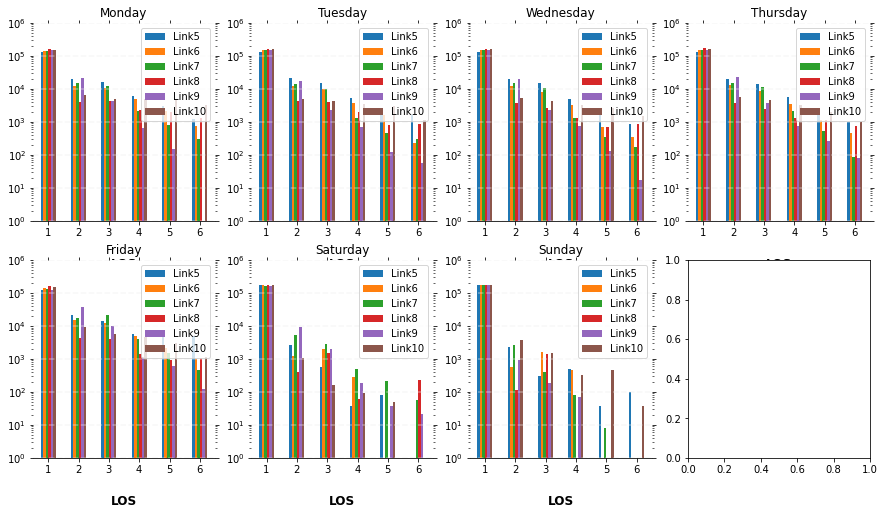

In [ ]:
dias_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axes = plt.subplots(nrows=2, ncols=4)
for weekday in range(0,7):
    plot_df = pd.DataFrame(index=[i for i in range(1,7)])
    for LINK in range(5,11):
        plot_df[f'Link{LINK}'] = training_df[(training_df['link_id']==LINK) & (training_df.index.weekday == weekday)].groupby('LOS_dep')['tt_arr'].count()
    plot_df.fillna(0)
    
    plot_df.plot.bar(ax=axes[math.floor(weekday/4),weekday%4], rot=0, figsize=(15,8), log=True)
    # Set title
    axes[math.floor(weekday/4),weekday%4].set_title(f'{dias_semana[weekday]}')

for x_col in axes:
    for x in x_col:
        if x.get_title() != '':
            # Despine
            x.spines['right'].set_visible(False)
            x.spines['top'].set_visible(False)
            x.spines['left'].set_visible(False)

            # Switch off ticks
            x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

            # Draw horizontal axis lines
            vals = x.get_yticks()
            for tick in vals:
                x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

            # Set y-lim
            x.set_ylim(top=1e6)

            # Set x-axis label
            x.set_xlabel(f"LOS", labelpad=20, weight='bold', size=12)

> Per hour link LOS histogram

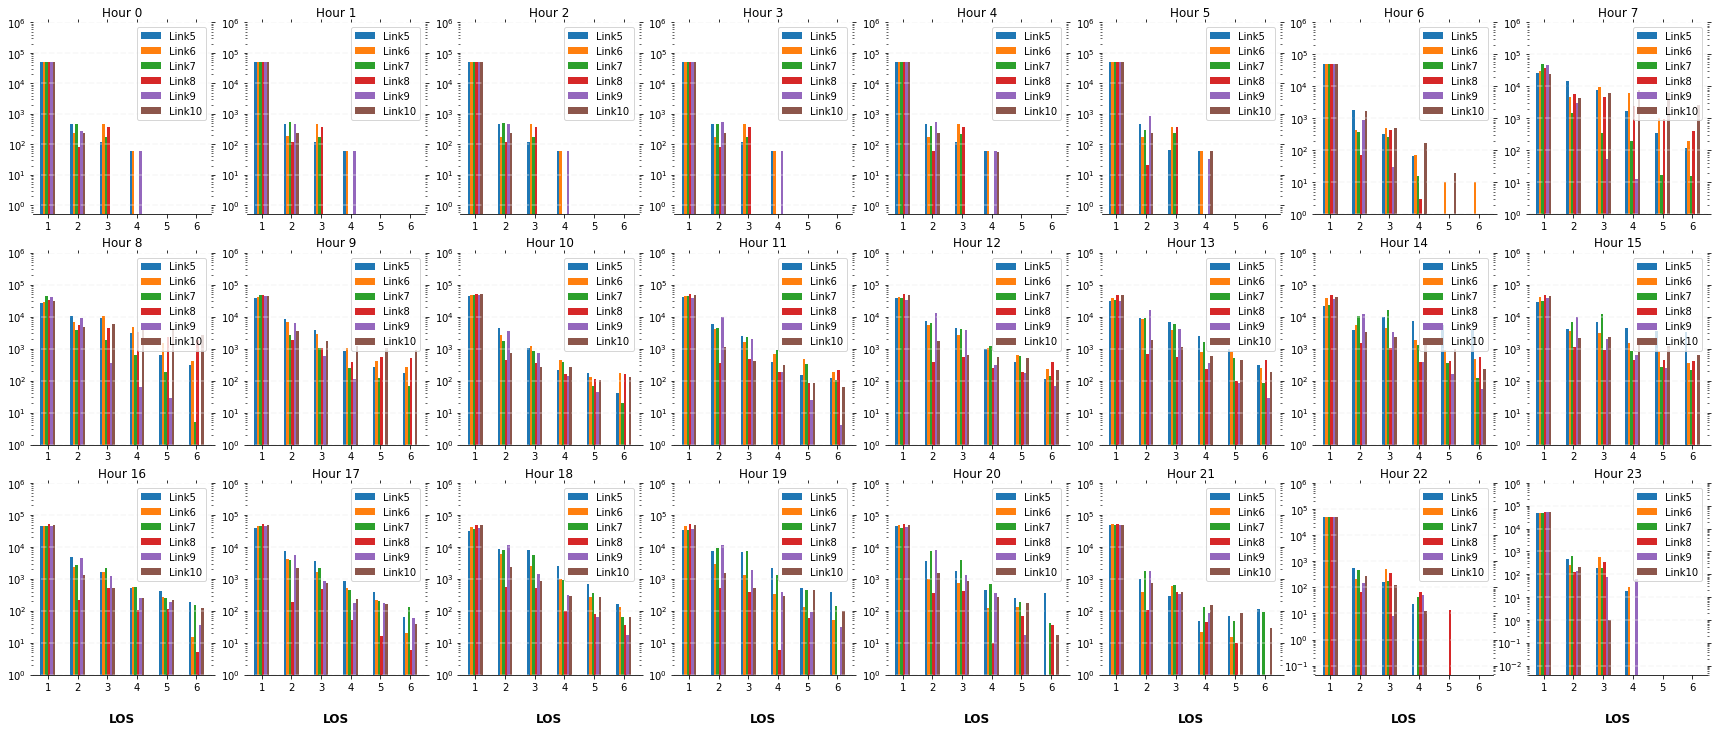

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=8)
for hour in range(0,24):
    plot_df = pd.DataFrame(index=[i for i in range(1,7)])
    for LINK in range(5,11):
        plot_df[f'Link{LINK}'] = training_df[(training_df['link_id']==LINK) & (training_df.index.hour == hour)].groupby('LOS_dep')['tt_arr'].count()
    plot_df.fillna(0)
    
    plot_df.plot.bar(ax=axes[math.floor(hour/8),hour%8], rot=0, figsize=(30,12), log=True)
    # Set title
    axes[math.floor(hour/8),hour%8].set_title(f'Hour {hour}')

for x_col in axes:
    for x in x_col:
        if x.get_title() != '':
            # Despine
            x.spines['right'].set_visible(False)
            x.spines['top'].set_visible(False)
            x.spines['left'].set_visible(False)

            # Switch off ticks
            x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

            # Draw horizontal axis lines
            vals = x.get_yticks()
            for tick in vals:
                x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

            # Set y-lim
            x.set_ylim(top=1e6)

            # Set x-axis label
            x.set_xlabel(f"LOS", labelpad=20, weight='bold', size=12)

> Statistical distribution of Times of Arrival per Level of Service

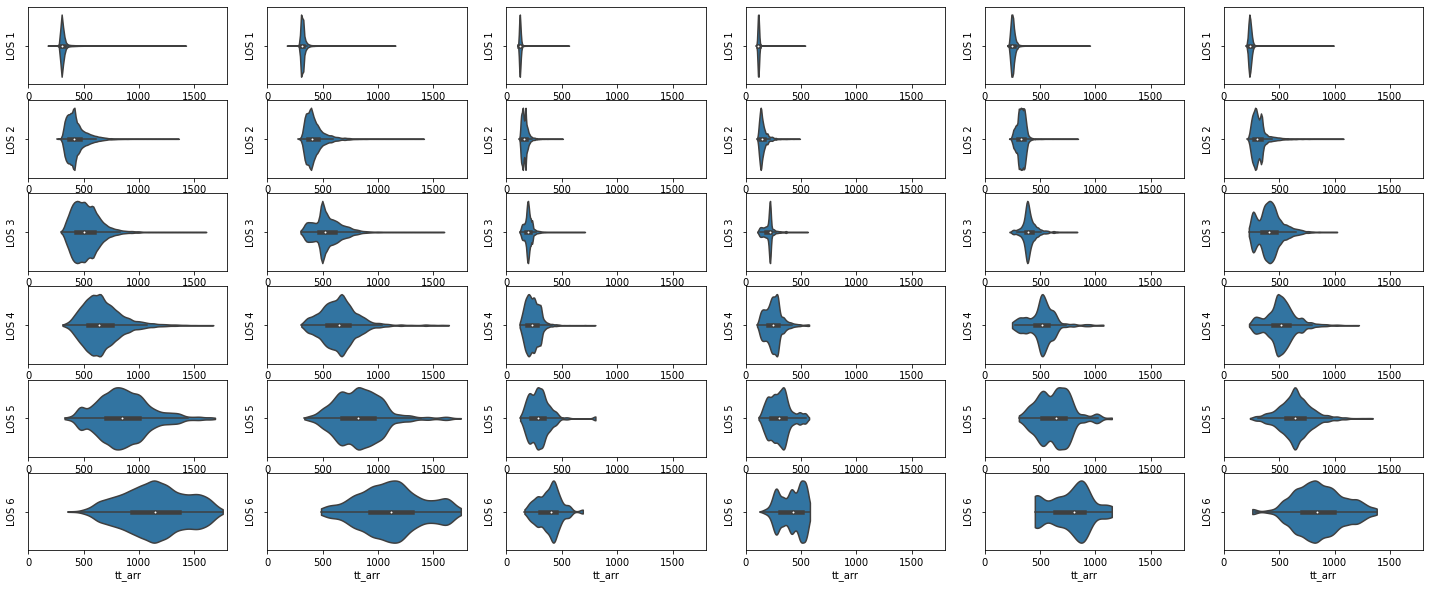

In [ ]:
fig, axs = plt.subplots(6,6)
fig.set_size_inches(25, 10)
for LINK in range(5,11):
    plot_df=training_df[(training_df['link_id']==LINK)]

    # Plot violinplot tt_arr per LOS
    for LOS in range(1,7):
        axs[LOS-1,LINK-5].set(xlim=(0, 1800))
        violinplot(data=plot_df[plot_df["LOS_dep"] == LOS], x="tt_arr", cut=0, ax=axs[LOS-1,LINK-5]).set(ylabel=f"LOS {LOS}")

## Statistical

> Features available

In [ ]:
training_df[['link_id','tt_arr','LOS_dep']].describe()

,link_id,tt_arr,LOS_dep
count,7.386120e+06,7.386120e+06,7.386120e+06
mean,7.500000e+00,2.466202e+02,1.214961e+00
std,1.707825e+00,1.247695e+02,6.847303e-01
min,5.000000e+00,9.400000e+01,1.000000e+00
25%,6.000000e+00,1.250000e+02,1.000000e+00
50%,7.500000e+00,2.440000e+02,1.000000e+00
75%,9.000000e+00,3.080000e+02,1.000000e+00
max,1.000000e+01,1.756500e+03,6.000000e+00


> Per-link id data balance





In [ ]:
training_df[training_df['LOS_dep']==4]['link_id'].value_counts()[training_df.link_id.unique()]

5     28407
6     20875
7     11497
8      8188
9      4173
10    20101
Name: link_id, dtype: int64

> Test normality of Times of Arrival

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    for LOS in range(1,7):
        print(f"\tLOS {LOS}\tPvalue {shapiro(training_df[(training_df['link_id']==LINK) & (training_df['LOS_dep']==LOS)]['tt_arr']).pvalue}")

LINK 5
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 0.0
	LOS 5	Pvalue 3.0895828541433567e-41
	LOS 6	Pvalue 5.011837864629182e-29
LINK 6
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 0.0
	LOS 5	Pvalue 8.23121877165319e-39
	LOS 6	Pvalue 1.0535939090175312e-16
LINK 7
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 0.0
	LOS 5	Pvalue 0.0
	LOS 6	Pvalue 6.297267937140083e-13
LINK 8
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 2.802596928649634e-45
	LOS 5	Pvalue 5.859512404482781e-33
	LOS 6	Pvalue 2.4114945272565777e-41
LINK 9
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 1.3216130666316006e-38
	LOS 5	Pvalue 3.42259417150919e-14
	LOS 6	Pvalue 7.32835389594122e-11
LINK 10
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 0.0
	LOS 5	Pvalue 1.401298464324817e-45
	LOS 6	Pvalue 1.0998466610191978e-22


# **NAIVE BAYES**

### **NO FEATURE ENGINEERING**

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    X_train = training_df[training_df['link_id'] == LINK]['tt_arr'].values.reshape(-1, 1)
    y_train = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
    
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)

    model = GaussianNB().fit(X_train, y_train)
    for LOS in range(1,7):
        X_test = sc.transform( validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1) )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 97.23%
	LOS 2: Recall 53.06%
	LOS 3: Recall 40.82%
	LOS 4: Recall 21.36%
	LOS 5: Recall 22.88%
	LOS 6: Recall 59.9%
LINK 6
	LOS 1: Recall 96.11%
	LOS 2: Recall 34.04%
	LOS 3: Recall 33.21%
	LOS 4: Recall 15.45%
	LOS 5: Recall 17.77%
	LOS 6: Recall 34.31%
LINK 7
	LOS 1: Recall 98.42%
	LOS 2: Recall 57.11%
	LOS 3: Recall 46.48%
	LOS 4: Recall 13.87%
	LOS 5: Recall 16.24%
	LOS 6: Recall 30.1%
LINK 8
	LOS 1: Recall 99.53%
	LOS 2: Recall 37.57%
	LOS 3: Recall 80.84%
	LOS 4: Recall 8.35%
	LOS 5: Recall 8.25%
	LOS 6: Recall 60.68%
LINK 9
	LOS 1: Recall 97.78%
	LOS 2: Recall 74.72%
	LOS 3: Recall 27.35%
	LOS 4: Recall 37.26%
	LOS 5: Recall 12.93%
	LOS 6: Recall 28.05%
LINK 10
	LOS 1: Recall 99.24%
	LOS 2: Recall 46.15%
	LOS 3: Recall 33.92%
	LOS 4: Recall 33.91%
	LOS 5: Recall 46.21%
	LOS 6: Recall 46.8%


### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

*Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df[training_df['link_id'] == LINK].copy()

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link]['tt_arr'], on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X_train = training_df_link.filter(regex=("tt_ar[^-]+$")).values
    y_train = training_df_link['LOS_dep'].values
    
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)

    model = GaussianNB().fit(X_train, y_train)
    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link]['tt_arr'], on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = sc.transform( validation_df_link.filter(regex=("tt_ar[^-]+$")).values )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 94.71%
	LOS 2: Recall 45.1%
	LOS 3: Recall 38.25%
	LOS 4: Recall 20.15%
	LOS 5: Recall 24.19%
	LOS 6: Recall 59.22%
LINK 6
	LOS 1: Recall 92.41%
	LOS 2: Recall 38.44%
	LOS 3: Recall 46.79%
	LOS 4: Recall 17.23%
	LOS 5: Recall 26.79%
	LOS 6: Recall 35.65%
LINK 7
	LOS 1: Recall 92.15%
	LOS 2: Recall 61.94%
	LOS 3: Recall 42.9%
	LOS 4: Recall 14.3%
	LOS 5: Recall 12.48%
	LOS 6: Recall 47.77%
LINK 8
	LOS 1: Recall 94.01%
	LOS 2: Recall 60.07%
	LOS 3: Recall 76.98%
	LOS 4: Recall 19.58%
	LOS 5: Recall 10.38%
	LOS 6: Recall 62.61%
LINK 9
	LOS 1: Recall 91.33%
	LOS 2: Recall 66.3%
	LOS 3: Recall 34.29%
	LOS 4: Recall 35.3%
	LOS 5: Recall 24.19%
	LOS 6: Recall 31.44%
LINK 10
	LOS 1: Recall 92.21%
	LOS 2: Recall 52.36%
	LOS 3: Recall 29.03%
	LOS 4: Recall 25.99%
	LOS 5: Recall 37.58%
	LOS 6: Recall 49.08%


### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [ ]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df[training_df['link_id'] == LINK].copy()

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X_train = training_df_link.filter(regex=("tt_arr.*")).values
    y_train = training_df_link['LOS_dep'].values
    
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)

    model = GaussianNB().fit(X_train, y_train)
    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = sc.transform( validation_df_link.filter(regex=("tt_arr.*")).values )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 92.13%
	LOS 2: Recall 39.55%
	LOS 3: Recall 29.16%
	LOS 4: Recall 19.54%
	LOS 5: Recall 23.77%
	LOS 6: Recall 62.57%
LINK 6
	LOS 1: Recall 89.42%
	LOS 2: Recall 33.89%
	LOS 3: Recall 39.04%
	LOS 4: Recall 15.23%
	LOS 5: Recall 22.03%
	LOS 6: Recall 41.77%
LINK 7
	LOS 1: Recall 88.72%
	LOS 2: Recall 58.36%
	LOS 3: Recall 28.98%
	LOS 4: Recall 20.79%
	LOS 5: Recall 11.4%
	LOS 6: Recall 37.96%
LINK 8
	LOS 1: Recall 89.82%
	LOS 2: Recall 32.24%
	LOS 3: Recall 68.63%
	LOS 4: Recall 34.23%
	LOS 5: Recall 15.5%
	LOS 6: Recall 48.55%
LINK 9
	LOS 1: Recall 87.66%
	LOS 2: Recall 53.49%
	LOS 3: Recall 17.93%
	LOS 4: Recall 3.58%
	LOS 5: Recall 16.82%
	LOS 6: Recall 47.88%
LINK 10
	LOS 1: Recall 87.75%
	LOS 2: Recall 33.32%
	LOS 3: Recall 17.89%
	LOS 4: Recall 17.53%
	LOS 5: Recall 19.25%
	LOS 6: Recall 48.41%


# **AdaBoost**

### *Algorithms*

**Algorithm implementation SAMME**

In [6]:
def labelToIndex(cl,clf):
    return clf.labelDict[cl]

def indexToLabel(i,clf):
    return clf.classes[i]

class AdaBoostClassifier_:
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        print("SAMME Implementation of AdaBoost")
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = [None]*n_estimators
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []
        self.observation_weights_ = {}
        
    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, )
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """
        
        # Initialize observation weights as 1/N where N is total `n_samples`
        N = df.shape[0]
        w = {epoch: 1/N for epoch in df.index}
        
        # Class labels mapping to indices
        self.createLabelDict(np.unique(df[y_column]))
        k = len(self.classes)

        # Training data initalization
        X_ = df.filter(regex=(X_columns)).values
        y_ = df[y_column].values
        w_indices_ = np.array(list(w.keys()))
        
        # M iterations (#WeakLearners)
        for m in range(self.n_estimators):
            w_ = np.array(list(w.values()))

        # 1) WeakLearner training
            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=w_).predict
        
        # 2) Error-rate computation
            incorrect = Gm(X_) != y_
            errM = np.average(incorrect,weights=w_,axis=0)
            self.estimator_errors_.append(np.average(incorrect,axis=0))
        
        # 3) WeakLearner weight for ensemble computation [errM < (k-1)/k]
            BetaM = np.log((1-errM)/errM)+np.log(k-1)
            self.models[m] = (BetaM,Gm)

        # 4) Observation weights update for next iteration with weights normalization
            w_ *= np.exp(self.learning_rate* BetaM*(incorrect*(w_ > 0)))
            norm_ = np.sum(w_)
            for i, j in enumerate(w_indices_):
                w[j] = w_[i]/norm_
        
        self.observation_weights_ = w
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i

    def predict(self,X):
        k = len(self.classes)
        Bms_ = [Bm for Bm,_ in self.models]
        prob_matrix = np.full((X.shape[0],k), -sum(Bms_)/(k-1))
        
        # Obtain the predicted index array with shape (#obs,#weak_learners)
        iTL = np.vectorize(labelToIndex)
        y_pred = np.stack([iTL(Gm(X),self) for _,Gm in self.models], axis=-1)

        # Weight the indices count using Beta (Bm) associated to each weak_learner
        prob_matrix += np.apply_along_axis(lambda x: np.bincount(x, weights=Bms_, minlength=k), axis=1, arr=y_pred)*k/(k-1)
        
        iTL = np.vectorize(indexToLabel)
        return iTL(np.argmax(prob_matrix,axis=1),self)

**Algorithm implementation SAMME.R**

In [4]:
def labelToIndex(cl,clf):
    return clf.labelDict[cl]

def indexToLabel(i,clf):
    return clf.classes[i]

class AdaBoostClassifier_:
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        print("SAMME.R Implementation of AdaBoost")
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []
        self.observation_weights_ = {}
        
    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, )
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """
        
        # Initialize observation weights as 1/N where N is total `n_samples`
        N = df.shape[0]
        w = {epoch: 1/N for epoch in df.index}
        
        # Class labels mapping to indices
        self.createLabelDict(np.unique(df[y_column]))
        k = len(self.classes)

        # Training data initalization
        X_ = df.filter(regex=(X_columns)).values
        y_ = df[y_column].values
        w_indices_ = np.array(list(w.keys()))
        
        # M iterations (#WeakLearners)
        for m in range(self.n_estimators):
            w_ = np.array(list(w.values()))

        # 1) WeakLearner training
            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=w_).predict_proba
            self.models.append(Gm)
        
        # 2) Error-rate computation
            sum_model_hypothesis = np.sum(np.stack([self._prob2classWeight_(model(X_)) for model in self.models], axis=-1), axis=-1)
            iTL = np.vectorize(indexToLabel)            
            incorrect = iTL(np.argmax(sum_model_hypothesis,axis=1),self) != y_
            self.estimator_errors_.append(np.average(incorrect,axis=0))

        # 3) Observation weights update for next iteration with weights normalization
            iTL = np.vectorize(labelToIndex)
            tmp_ = iTL(y_,self)
            w_ *= np.exp(-self.learning_rate* (k-1)/k * np.log(Gm(X_)[np.arange(len(tmp_)),tmp_]))
            norm_ = sum(w_)
            for i, j in enumerate(w_indices_):
                w[j] = w_[i]/norm_
        
        self.observation_weights_ = w
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i

    def _prob2classWeight_(self, probabilities):
        """
        Following the SAMME.R algorithm, returns the hypothesis probabilities for each class
        param probabilities: The class probabiilties output by the fitted model (n_samples, n_classes)
        """
        k = len(self.classes)
        tmp_ = np.log(probabilities+1e-8)
        h_k = np.log(probabilities+1e-8)
        for i in range(k):
            h_k[:,i] -= np.sum(np.delete(tmp_,i,axis=1), axis=1) / k
        h_k *= (k-1)
        return h_k
    
    def predict(self,X):
        sum_model_hypothesis = np.sum(np.stack([self._prob2classWeight_(model(X)) for model in self.models], axis=-1), axis=-1)
        iTL = np.vectorize(indexToLabel)            
        return iTL(np.argmax(sum_model_hypothesis,axis=1),self)

**Algorithm implementation M2**

In [6]:
def labelToIndex(cl,clf):
    return clf.labelDict[cl]

def indexToLabel(i,clf):
    return clf.classes[i]

class AdaBoostClassifier_:
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        print("M2 Implementation of AdaBoost")
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []        
        self.observation_weights_ = {}

    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, )
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """        
        
        # Class labels mapping to indices
        self.createLabelDict(np.unique(df[y_column]))
        k = len(self.classes)

        # Initialize observation weights as 1/(N*(k-1)) where N is total `n_samples` and k is the numebr of classes
        N = df.shape[0]
        B = N*(k-1)
        D = {epoch: [1/B]*(k-1) for epoch in df.index}

        # Training data initalization
        X_ = df.filter(regex=(X_columns)).values
        y_ = df[y_column].values
        
        # M iterations (#WeakLearners)
        for m in range(self.n_estimators):
            D_ = np.sum(list(D.values()), axis=-1)
            iTL = np.vectorize(labelToIndex)
            y_indices_ = iTL(y_,self)

        # 1) WeakLearner training
            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=D_).predict_proba
            self.models.append(Gm)
        
        # 2) Error-rate computation
            predictions_proba = Gm(X_)
            sum_pseudolosses = 0
            for i, epoch in enumerate(D):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices_[i]:
                        sum_pseudolosses += D[epoch][k_index]*(1-predictions_proba[i,y_indices_[i]]+predictions_proba[i,cl])
                        k_index += 1

            error = 0.5 * sum_pseudolosses
            self.estimator_errors_.append(error)
        
        # 3) WeakLearner weight for ensemble computation
            BetaM = error/(1- error +1e-8)
            self.models[m] = (BetaM,Gm)

        # 4) Observation weights update for next iteration with weights normalization
            norm_ = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices_[i]:
                        w_ = 0.5*(1+predictions_proba[i,y_indices_[i]]-predictions_proba[i,cl])
                        D[epoch][k_index] *= BetaM**(self.learning_rate*w_)
                        norm_ += D[epoch][k_index]
                        k_index += 1
            for epoch in D.keys():
                for k_index in range(k-1):
                    D[epoch][k_index] /= norm_
        
        self.observation_weights_ = D
        
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i
    
    def predict(self,X):
        sum_model_hypothesis = np.sum(np.stack([-np.log(Bm)*Gm(X) for Bm,Gm in self.models], axis=-1), axis=-1)
        iTL = np.vectorize(indexToLabel)            
        return iTL(np.argmax(sum_model_hypothesis,axis=1),self)

### **NO FEATURE ENGINEERING SAMME**

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME_nofeat_link{LINK}.joblib'

    # Max Depth = 3 because we have 6 possible classes (2^3=8)
    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], 'tt_arr$', 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 95.69%
	LOS 2: Recall 56.05%
	LOS 3: Recall 55.62%
	LOS 4: Recall 29.12%
	LOS 5: Recall 31.17%
	LOS 6: Recall 72.0%
LINK 6
	LOS 1: Recall 97.54%
	LOS 2: Recall 34.74%
	LOS 3: Recall 76.62%
	LOS 4: Recall 15.01%
	LOS 5: Recall 22.07%
	LOS 6: Recall 48.95%
LINK 7
	LOS 1: Recall 97.44%
	LOS 2: Recall 61.72%
	LOS 3: Recall 67.67%
	LOS 4: Recall 4.63%
	LOS 5: Recall 23.02%
	LOS 6: Recall 47.12%
LINK 8
	LOS 1: Recall 99.37%
	LOS 2: Recall 44.37%
	LOS 3: Recall 75.47%
	LOS 4: Recall 39.53%
	LOS 5: Recall 34.54%
	LOS 6: Recall 52.46%
LINK 9
	LOS 1: Recall 97.6%
	LOS 2: Recall 73.01%
	LOS 3: Recall 52.44%
	LOS 4: Recall 59.9%
	LOS 5: Recall 48.26%
	LOS 6: Recall 39.66%
LINK 10
	LOS 1: Recall 98.73%
	LOS 2: Recall 54.63%
	LOS 3: Recall 47.7%
	LOS 4: Recall 47.09%
	LOS 5: Recall 51.94%
	LOS 6: Recall 55.55%


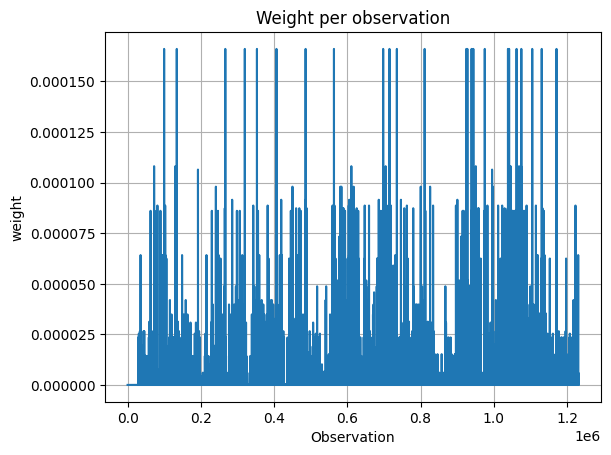

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(model.observation_weights_)), model.observation_weights_.values())

ax.set(xlabel='Observation', ylabel='weight',
       title='Weight per observation')
ax.grid()
plt.show()

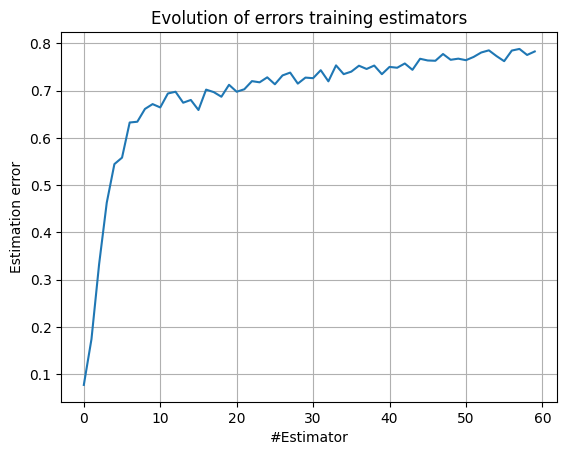

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

*Validate with implementation from sklearn*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    X = training_df[training_df['link_id'] == LINK]['tt_arr'].values.reshape(-1, 1)
    y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values

    model = AdaBoostClassifier(n_estimators=60, learning_rate=0.3, algorithm="SAMME").fit(X, y)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 93.5%
	LOS 2: Recall 67.2%
	LOS 3: Recall 55.96%
	LOS 4: Recall 23.94%
	LOS 5: Recall 34.87%
	LOS 6: Recall 63.43%
LINK 6
	LOS 1: Recall 97.04%
	LOS 2: Recall 46.95%
	LOS 3: Recall 79.21%
	LOS 4: Recall 7.75%
	LOS 5: Recall 23.48%
	LOS 6: Recall 35.12%
LINK 7
	LOS 1: Recall 97.44%
	LOS 2: Recall 61.72%
	LOS 3: Recall 68.97%
	LOS 4: Recall 4.62%
	LOS 5: Recall 15.7%
	LOS 6: Recall 0.0%
LINK 8
	LOS 1: Recall 99.2%
	LOS 2: Recall 53.62%
	LOS 3: Recall 77.87%
	LOS 4: Recall 28.76%
	LOS 5: Recall 21.08%
	LOS 6: Recall 59.14%
LINK 9
	LOS 1: Recall 97.35%
	LOS 2: Recall 73.33%
	LOS 3: Recall 61.51%
	LOS 4: Recall 59.9%
	LOS 5: Recall 51.63%
	LOS 6: Recall 0.0%
LINK 10
	LOS 1: Recall 98.71%
	LOS 2: Recall 56.87%
	LOS 3: Recall 53.61%
	LOS 4: Recall 36.83%
	LOS 5: Recall 54.03%
	LOS 6: Recall 43.27%


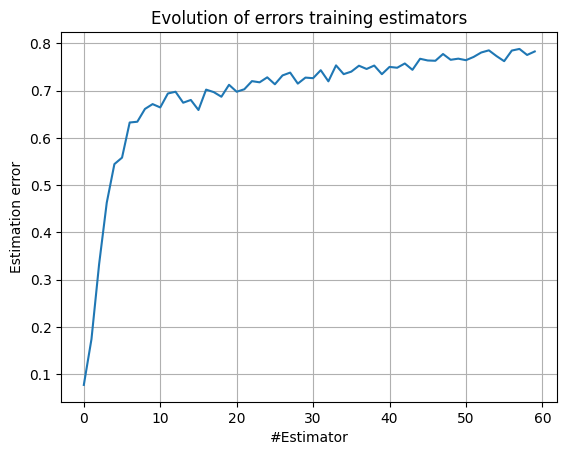

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

### **NO FEATURE ENGINEERING SAMME.R**

In [5]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME.R_nofeat_link{LINK}.joblib'

    # Max Depth = 3 because we have 6 possible classes (2^3=8 separable regions)
    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], 'tt_arr$', 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 95.53%
	LOS 2: Recall 58.66%
	LOS 3: Recall 58.82%
	LOS 4: Recall 28.78%
	LOS 5: Recall 23.0%
	LOS 6: Recall 63.43%
LINK 6
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 97.77%
	LOS 2: Recall 31.94%
	LOS 3: Recall 77.72%
	LOS 4: Recall 14.45%
	LOS 5: Recall 22.91%
	LOS 6: Recall 36.76%
LINK 7
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 97.9%
	LOS 2: Recall 57.11%
	LOS 3: Recall 67.01%
	LOS 4: Recall 15.27%
	LOS 5: Recall 10.89%
	LOS 6: Recall 37.83%
LINK 8
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 99.5%
	LOS 2: Recall 37.08%
	LOS 3: Recall 79.54%
	LOS 4: Recall 28.26%
	LOS 5: Recall 25.08%
	LOS 6: Recall 52.46%
LINK 9
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 97.66%
	LOS 2: Recall 71.86%
	LOS 3: Recall 52.44%
	LOS 4: Recall 59.9%
	LOS 5: Recall 47.0%
	LOS 6: Recall 11.61%
LINK 10
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 98.75%
	LOS 2: Recall 55.42%
	LOS 3: Recall 48.72%
	LOS 4: Recall 47.09%
	LOS

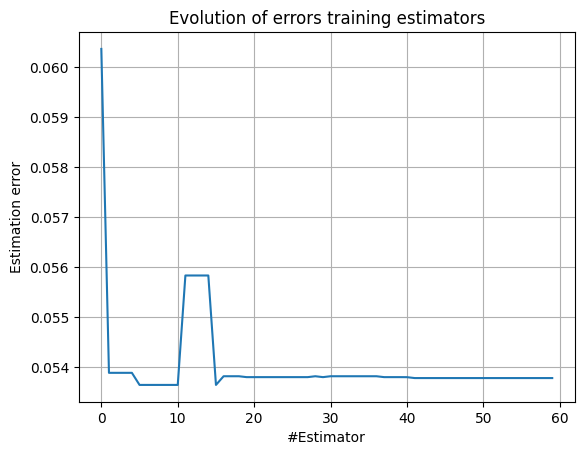

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

*Validate with implementation from sklearn*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    X = training_df[training_df['link_id'] == LINK]['tt_arr'].values.reshape(-1, 1)
    y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values

    model = AdaBoostClassifier(n_estimators=60, learning_rate=0.3, algorithm="SAMME.R").fit(X, y)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 93.5%
	LOS 2: Recall 67.2%
	LOS 3: Recall 55.96%
	LOS 4: Recall 23.94%
	LOS 5: Recall 34.87%
	LOS 6: Recall 63.43%
LINK 6
	LOS 1: Recall 97.04%
	LOS 2: Recall 46.95%
	LOS 3: Recall 79.21%
	LOS 4: Recall 7.75%
	LOS 5: Recall 23.48%
	LOS 6: Recall 35.12%
LINK 7
	LOS 1: Recall 97.44%
	LOS 2: Recall 61.72%
	LOS 3: Recall 68.97%
	LOS 4: Recall 4.62%
	LOS 5: Recall 15.7%
	LOS 6: Recall 0.0%
LINK 8
	LOS 1: Recall 99.2%
	LOS 2: Recall 53.62%
	LOS 3: Recall 77.87%
	LOS 4: Recall 28.76%
	LOS 5: Recall 21.08%
	LOS 6: Recall 59.14%
LINK 9
	LOS 1: Recall 97.35%
	LOS 2: Recall 73.33%
	LOS 3: Recall 61.51%
	LOS 4: Recall 59.9%
	LOS 5: Recall 51.63%
	LOS 6: Recall 0.0%
LINK 10
	LOS 1: Recall 98.71%
	LOS 2: Recall 56.87%
	LOS 3: Recall 53.61%
	LOS 4: Recall 36.83%
	LOS 5: Recall 54.03%
	LOS 6: Recall 43.27%


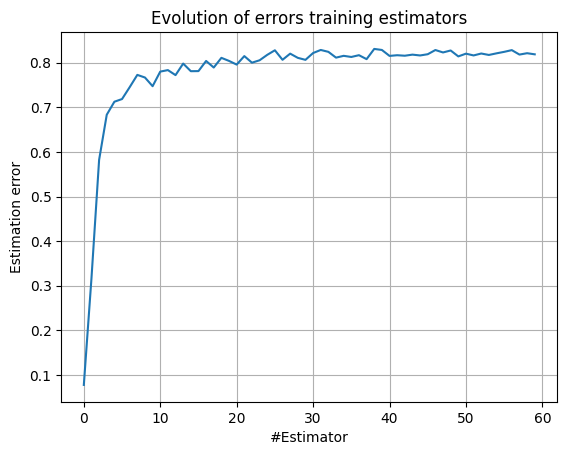

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

### **NO FEATURE ENGINEERING M2**

In [8]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'/{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_M2_nofeat_link{LINK}.joblib'

    # Max Depth = 3 because we have 6 possible classes (2^3=8 separable regions)
    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], 'tt_arr$', 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of AdaBoost
	LOS 1: Recall 95.62%
	LOS 2: Recall 61.56%
	LOS 3: Recall 57.07%
	LOS 4: Recall 17.41%
	LOS 5: Recall 15.1%
	LOS 6: Recall 71.52%
LINK 6
M2 Implementation of AdaBoost
	LOS 1: Recall 97.77%
	LOS 2: Recall 31.89%
	LOS 3: Recall 79.46%
	LOS 4: Recall 7.75%
	LOS 5: Recall 28.49%
	LOS 6: Recall 0.0%
LINK 7
M2 Implementation of AdaBoost
	LOS 1: Recall 97.88%
	LOS 2: Recall 57.3%
	LOS 3: Recall 70.9%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
M2 Implementation of AdaBoost
	LOS 1: Recall 99.47%
	LOS 2: Recall 38.62%
	LOS 3: Recall 80.61%
	LOS 4: Recall 32.78%
	LOS 5: Recall 0.0%
	LOS 6: Recall 59.14%
LINK 9
M2 Implementation of AdaBoost
	LOS 1: Recall 97.61%
	LOS 2: Recall 72.69%
	LOS 3: Recall 52.45%
	LOS 4: Recall 71.82%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
M2 Implementation of AdaBoost
	LOS 1: Recall 98.85%
	LOS 2: Recall 53.68%
	LOS 3: Recall 48.04%
	LOS 4: Recall 47.61%
	LOS 5: Recall 51.14%
	LOS 6: Recall 55.55%


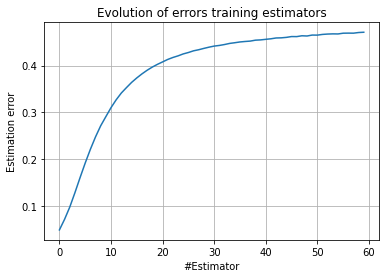

In [9]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

## Feature engineering SAMME

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

*Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

In [7]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME_adjacent_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_ar[^-]+$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_ar[^-]+$")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
SAMME Implementation of AdaBoost
	LOS 1: Recall 95.71%
	LOS 2: Recall 52.89%
	LOS 3: Recall 55.61%
	LOS 4: Recall 19.4%
	LOS 5: Recall 33.17%
	LOS 6: Recall 68.93%
LINK 6
SAMME Implementation of AdaBoost
	LOS 1: Recall 97.82%
	LOS 2: Recall 31.19%
	LOS 3: Recall 74.82%
	LOS 4: Recall 23.47%
	LOS 5: Recall 29.7%
	LOS 6: Recall 48.95%
LINK 7
SAMME Implementation of AdaBoost
	LOS 1: Recall 97.8%
	LOS 2: Recall 51.25%
	LOS 3: Recall 66.65%
	LOS 4: Recall 15.75%
	LOS 5: Recall 24.65%
	LOS 6: Recall 7.46%
LINK 8
SAMME Implementation of AdaBoost
	LOS 1: Recall 99.37%
	LOS 2: Recall 43.4%
	LOS 3: Recall 77.95%
	LOS 4: Recall 33.17%
	LOS 5: Recall 32.42%
	LOS 6: Recall 52.46%
LINK 9
SAMME Implementation of AdaBoost
	LOS 1: Recall 97.99%
	LOS 2: Recall 69.08%
	LOS 3: Recall 49.81%
	LOS 4: Recall 55.8%
	LOS 5: Recall 33.12%
	LOS 6: Recall 2.27%
LINK 10
SAMME Implementation of AdaBoost
	LOS 1: Recall 98.89%
	LOS 2: Recall 49.52%
	LOS 3: Recall 46.41%
	LOS 4: Recall 44.45%
	LOS 5: Recall 51.

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [23]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME_temp{INPUT_MINUTES_BEFORE}m_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_arr.*", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

USING PREVIOUS 45m INFORMATION
LINK 5
SAMME Implementation of AdaBoost
	LOS 1: Recall 96.0%
	LOS 2: Recall 50.11%
	LOS 3: Recall 53.99%
	LOS 4: Recall 19.38%
	LOS 5: Recall 34.58%
	LOS 6: Recall 67.33%
LINK 6
SAMME Implementation of AdaBoost
	LOS 1: Recall 97.96%
	LOS 2: Recall 34.49%
	LOS 3: Recall 75.16%
	LOS 4: Recall 25.57%
	LOS 5: Recall 30.01%
	LOS 6: Recall 46.15%
LINK 7
SAMME Implementation of AdaBoost
	LOS 1: Recall 97.91%
	LOS 2: Recall 51.23%
	LOS 3: Recall 66.12%
	LOS 4: Recall 16.72%
	LOS 5: Recall 9.88%
	LOS 6: Recall 8.51%
LINK 8
SAMME Implementation of AdaBoost
	LOS 1: Recall 99.35%
	LOS 2: Recall 38.54%
	LOS 3: Recall 77.63%
	LOS 4: Recall 39.53%
	LOS 5: Recall 25.67%
	LOS 6: Recall 55.4%
LINK 9
SAMME Implementation of AdaBoost
	LOS 1: Recall 97.79%
	LOS 2: Recall 70.68%
	LOS 3: Recall 49.54%
	LOS 4: Recall 63.22%
	LOS 5: Recall 35.23%
	LOS 6: Recall 0.57%
LINK 10
SAMME Implementation of AdaBoost
	LOS 1: Recall 98.77%
	LOS 2: Recall 53.79%
	LOS 3: Recall 48.83%
	LOS 4:

## Feature engineering SAMME.R

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

*Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

In [9]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME.R_adjacent_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_ar[^-]+$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_ar[^-]+$")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 95.89%
	LOS 2: Recall 44.87%
	LOS 3: Recall 43.68%
	LOS 4: Recall 22.51%
	LOS 5: Recall 25.27%
	LOS 6: Recall 55.17%
LINK 6
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 98.09%
	LOS 2: Recall 32.8%
	LOS 3: Recall 76.65%
	LOS 4: Recall 23.32%
	LOS 5: Recall 27.52%
	LOS 6: Recall 32.61%
LINK 7
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 97.95%
	LOS 2: Recall 56.35%
	LOS 3: Recall 68.74%
	LOS 4: Recall 11.74%
	LOS 5: Recall 5.81%
	LOS 6: Recall 27.62%
LINK 8
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 99.48%
	LOS 2: Recall 39.33%
	LOS 3: Recall 79.74%
	LOS 4: Recall 31.21%
	LOS 5: Recall 19.92%
	LOS 6: Recall 58.52%
LINK 9
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 97.89%
	LOS 2: Recall 71.12%
	LOS 3: Recall 50.73%
	LOS 4: Recall 49.43%
	LOS 5: Recall 28.08%
	LOS 6: Recall 10.48%
LINK 10
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 98.75%
	LOS 2: Recall 55.89%
	LOS 3: Recall 48.78%
	LOS 4: Recall 44.04%
	

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [10]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME.R_temp{INPUT_MINUTES_BEFORE}m_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_arr.*", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

USING PREVIOUS 45m INFORMATION
LINK 5
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 95.34%
	LOS 2: Recall 45.53%
	LOS 3: Recall 52.55%
	LOS 4: Recall 23.27%
	LOS 5: Recall 26.99%
	LOS 6: Recall 60.14%
LINK 6
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 98.15%
	LOS 2: Recall 26.18%
	LOS 3: Recall 78.65%
	LOS 4: Recall 20.48%
	LOS 5: Recall 25.6%
	LOS 6: Recall 24.97%
LINK 7
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 97.96%
	LOS 2: Recall 57.69%
	LOS 3: Recall 67.62%
	LOS 4: Recall 12.47%
	LOS 5: Recall 7.02%
	LOS 6: Recall 29.45%
LINK 8
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 99.52%
	LOS 2: Recall 36.22%
	LOS 3: Recall 78.37%
	LOS 4: Recall 30.48%
	LOS 5: Recall 15.04%
	LOS 6: Recall 58.13%
LINK 9
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 97.76%
	LOS 2: Recall 71.65%
	LOS 3: Recall 51.81%
	LOS 4: Recall 41.75%
	LOS 5: Recall 36.17%
	LOS 6: Recall 0.0%
LINK 10
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 98.75%
	LOS 2: Recall 53.66%
	LOS 3: Recall 5

## Feature engineering M2

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

*Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

In [15]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_M2_adjacent_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_ar[^-]+$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_ar[^-]+$")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of AdaBoost
	LOS 1: Recall 95.36%
	LOS 2: Recall 58.94%
	LOS 3: Recall 58.36%
	LOS 4: Recall 18.6%
	LOS 5: Recall 15.1%
	LOS 6: Recall 71.52%
LINK 6
M2 Implementation of AdaBoost
	LOS 1: Recall 98.18%
	LOS 2: Recall 31.09%
	LOS 3: Recall 79.67%
	LOS 4: Recall 7.75%
	LOS 5: Recall 28.49%
	LOS 6: Recall 0.0%
LINK 7
M2 Implementation of AdaBoost
	LOS 1: Recall 97.8%
	LOS 2: Recall 57.37%
	LOS 3: Recall 72.43%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
M2 Implementation of AdaBoost
	LOS 1: Recall 99.44%
	LOS 2: Recall 41.34%
	LOS 3: Recall 80.62%
	LOS 4: Recall 28.82%
	LOS 5: Recall 7.29%
	LOS 6: Recall 57.64%
LINK 9
M2 Implementation of AdaBoost
	LOS 1: Recall 97.66%
	LOS 2: Recall 73.08%
	LOS 3: Recall 55.14%
	LOS 4: Recall 8.03%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
M2 Implementation of AdaBoost
	LOS 1: Recall 98.83%
	LOS 2: Recall 54.28%
	LOS 3: Recall 48.04%
	LOS 4: Recall 47.61%
	LOS 5: Recall 51.14%
	LOS 6: Recall 55.55%


### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [16]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_M2_temp{INPUT_MINUTES_BEFORE}m_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_arr.*", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

USING PREVIOUS 45m INFORMATION
LINK 5
M2 Implementation of AdaBoost
	LOS 1: Recall 94.91%
	LOS 2: Recall 59.05%
	LOS 3: Recall 59.09%
	LOS 4: Recall 18.6%
	LOS 5: Recall 15.1%
	LOS 6: Recall 71.52%
LINK 6
M2 Implementation of AdaBoost
	LOS 1: Recall 98.19%
	LOS 2: Recall 31.06%
	LOS 3: Recall 79.68%
	LOS 4: Recall 7.75%
	LOS 5: Recall 28.49%
	LOS 6: Recall 0.0%
LINK 7
M2 Implementation of AdaBoost
	LOS 1: Recall 97.78%
	LOS 2: Recall 57.54%
	LOS 3: Recall 72.55%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
M2 Implementation of AdaBoost
	LOS 1: Recall 99.44%
	LOS 2: Recall 40.55%
	LOS 3: Recall 80.63%
	LOS 4: Recall 28.74%
	LOS 5: Recall 7.29%
	LOS 6: Recall 57.64%
LINK 9
M2 Implementation of AdaBoost
	LOS 1: Recall 97.67%
	LOS 2: Recall 73.05%
	LOS 3: Recall 48.59%
	LOS 4: Recall 71.82%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
M2 Implementation of AdaBoost
	LOS 1: Recall 98.83%
	LOS 2: Recall 54.6%
	LOS 3: Recall 53.54%
	LOS 4: Recall 39.07%
	LOS 5: Recall 

# **RUSBoost**

### *Algorithms*

**Algorithm implementation SAMME**

In [17]:
def labelToIndex(i,clf):
    return clf.labelDict[i]

def indexToLabel(i,clf):
    return clf.classes[i]

class RUSBoostClassifier_:
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        print("SAMME Implementation of RUSBoost")
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = [None]*n_estimators
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []
        self.observation_weights_ = {}
        
    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, )
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """
        
        # Initialize observation weights as 1/N where N is total `n_samples`
        N = df.shape[0]
        w = {epoch: 1/N for epoch in df.index}
        
        # `undersampling_n` elements to sample from each class, equal #samples minority class
        self.createLabelDict(np.unique(df[y_column]))
        k = len(self.classes)
        undersampling_n = min(df[y_column].value_counts())

        # Get whole dataset samples to later calculate the weighting factors on every iteration
        X = df.filter(regex=(X_columns)).values
        y = df[y_column].values
        
        # M iterations (#WeakLearners)
        for m in range(self.n_estimators):
            
        # 1) Random UnderSampling
            df_ = pd.DataFrame()
            for label_ in self.classes:
                # Quizas muestrear usando la inversa de los pesos (.sample(weights=1/w)) para hacer overfit en los casos con menos error == underfit
                df_ = pd.concat([ df_, df[ df[y_column]==label_ ].sample(undersampling_n, replace=False) ])
            
            # Indices are dates in integer format
            w_ = np.array([w[epoch] for epoch in df_.index])

            X_ = df_.filter(regex=(X_columns)).values
            y_ = df_[y_column].values

        # 2) WeakLearner training
            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=w_).predict
        
        # 3) Error-rate computation
            incorrect = Gm(X) != y
            errM = np.average(incorrect,weights=list(w.values()),axis=0)
            self.estimator_errors_.append(errM)
        
        # 4) WeakLearner weight for ensemble computation [errM < (k-1)/k]
            BetaM = np.log((1-errM)/errM)+np.log(k-1)            
            self.models[m] = (BetaM,Gm)

        # 5) Observation weights update for next iteration with weights normalization
            norm_ = 0
            w_ = np.array(list(w.values()))
            positive_mask = w_ > 0
            w_ *= np.exp(self.learning_rate* BetaM*(incorrect * positive_mask))
            for i, epoch in enumerate(w.keys()):
                w[epoch] = w_[i]
                norm_ += w_[i]
            for epoch in w.keys():
                w[epoch] /= norm_
        
        self.observation_weights_ = w
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i

    def predict(self,X):
        k = len(self.classes)
        Bms_ = [Bm for Bm,_ in self.models]
        prob_matrix = np.full((X.shape[0],k), -sum(Bms_)/(k-1))
        
        # Obtain the predicted index array with shape (#obs,#weak_learners)
        iTL = np.vectorize(labelToIndex)
        y_pred = np.stack([iTL(Gm(X),self) for _,Gm in self.models], axis=-1)

        # Weight the indices count using Bm associated to each weak_learner
        prob_matrix += np.apply_along_axis(lambda x: np.bincount(x, weights=Bms_, minlength=k), axis=1, arr=y_pred)*k/(k-1)
        
        iTL = np.vectorize(indexToLabel)
        return iTL(np.argmax(prob_matrix,axis=1),self)

**Algorithm implementation M2**

In [19]:
def labelToIndex(cl,clf):
    return clf.labelDict[cl]

def indexToLabel(i,clf):
    return clf.classes[i]

class RUSBoostClassifier_:
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        print("M2 Implementation of RUSBoost")
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []
        self.observation_weights_ = {}

    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, )
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """        
        
        # Class labels mapping to indices
        self.createLabelDict(np.unique(df[y_column]))
        k = len(self.classes)
        # `undersampling_n` elements to sample from each class, equal #samples minority class
        undersampling_n = min(df[y_column].value_counts())

        # Initialize observation weights as 1/(N*(k-1)) where N is total `n_samples` and k is the numebr of classes
        N = df.shape[0]
        B = N*(k-1)
        D = {epoch: np.full(k-1,1/B) for epoch in df.index}

        # Get whole dataset samples to later calculate the weighting factors on every iteration
        X = df.filter(regex=(X_columns)).values
        y = df[y_column].values
        iTL = np.vectorize(labelToIndex)
        y_indices = iTL(y,self)
        
        # M iterations (#WeakLearners)
        for m in range(self.n_estimators):

        # 1) Random UnderSampling
            df_ = pd.DataFrame()
            for label_ in self.classes:
                # Quizas muestrear usando la inversa de los pesos (.sample(weights=1/w)) para hacer overfit en los casos con menos error == underfit
                df_ = pd.concat([ df_, df[ df[y_column]==label_ ].sample(undersampling_n, replace=False) ])

            
            # Training data initalization
            X_ = df_.filter(regex=(X_columns)).values
            y_ = df_[y_column].values
            D_ = np.sum([D[epoch] for epoch in df_.index], axis=-1)

        # 2) WeakLearner training
            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=D_).predict_proba
            self.models.append(Gm)
        
        # 3) Error-rate computation
            predictions_proba = Gm(X)
            sum_pseudolosses = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        sum_pseudolosses += D[epoch][k_index]*(1-predictions_proba[i,y_indices[i]]+predictions_proba[i,cl])
                        k_index += 1

            error = 0.5 * sum_pseudolosses
            self.estimator_errors_.append(error)
        
        # 4) WeakLearner weight for ensemble computation
            BetaM = error/(1-error)
            self.models[m] = (BetaM,Gm)

        # 5) Observation weights update for next iteration with weights normalization
            norm_ = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        w_ = 0.5*(1+predictions_proba[i,y_indices[i]]-predictions_proba[i,cl])
                        D[epoch][k_index] *= BetaM**(self.learning_rate*w_)
                        norm_ += D[epoch][k_index]
                        k_index += 1
            for epoch in D.keys():
                D[epoch] /= norm_
        
        self.observation_weights_ = D
        
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i
    
    def predict(self,X):
        sum_model_hypothesis = np.sum(np.stack([-np.log(Bm)*Gm(X) for Bm,Gm in self.models], axis=-1), axis=-1)
        iTL = np.vectorize(indexToLabel)            
        return iTL(np.argmax(sum_model_hypothesis,axis=1),self)


### **NO FEATURE ENGINEERING SAMME**

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/RUSBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME_nofeat_link{LINK}.joblib'

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], 'tt_arr$', 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
SAMME Implementation of RUSBoost
	LOS 1: Recall 88.13%
	LOS 2: Recall 67.61%
	LOS 3: Recall 41.42%
	LOS 4: Recall 30.92%
	LOS 5: Recall 58.25%
	LOS 6: Recall 65.74%
LINK 6
SAMME Implementation of RUSBoost
	LOS 1: Recall 88.83%
	LOS 2: Recall 70.36%
	LOS 3: Recall 42.64%
	LOS 4: Recall 27.05%
	LOS 5: Recall 69.26%
	LOS 6: Recall 50.12%
LINK 7
SAMME Implementation of RUSBoost
	LOS 1: Recall 89.03%
	LOS 2: Recall 71.48%
	LOS 3: Recall 63.45%
	LOS 4: Recall 8.46%
	LOS 5: Recall 33.53%
	LOS 6: Recall 67.8%
LINK 8
SAMME Implementation of RUSBoost
	LOS 1: Recall 96.62%
	LOS 2: Recall 71.89%
	LOS 3: Recall 68.17%
	LOS 4: Recall 48.21%
	LOS 5: Recall 0.0%
	LOS 6: Recall 75.66%
LINK 9
SAMME Implementation of RUSBoost
	LOS 1: Recall 93.38%
	LOS 2: Recall 78.64%
	LOS 3: Recall 57.15%
	LOS 4: Recall 54.06%
	LOS 5: Recall 11.67%
	LOS 6: Recall 63.17%
LINK 10
SAMME Implementation of RUSBoost
	LOS 1: Recall 93.11%
	LOS 2: Recall 72.25%
	LOS 3: Recall 54.19%
	LOS 4: Recall 40.77%
	LOS 5: Recall 

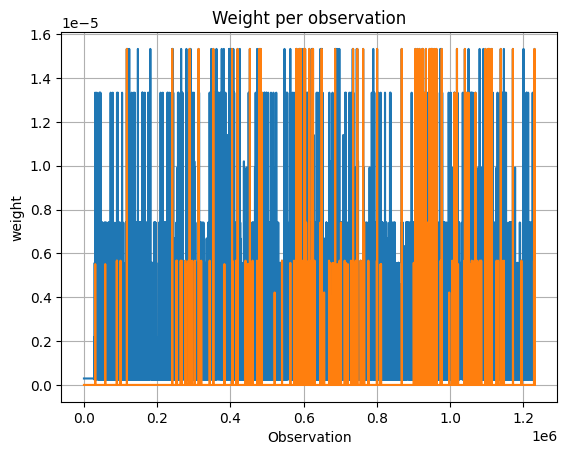

In [ ]:
fig, ax = plt.subplots()

ax.plot(np.arange(len(model.observation_weights_)), model.observation_weights_.values())

tmp = training_df[training_df['link_id'] == LINK]
ax.plot(np.arange(len(model.observation_weights_)), np.array(list(model.observation_weights_.values()))*np.array(tmp['LOS_dep'] == 6).astype(np.int8).astype(np.int8))

ax.set(xlabel='Observation', ylabel='weight',
       title='Weight per observation')
ax.grid()
plt.show()

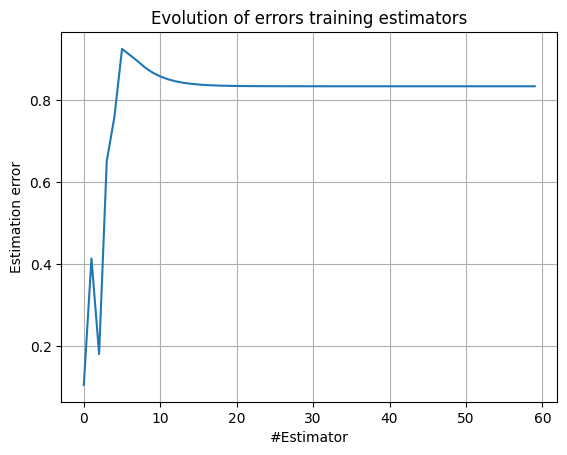

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

### **NO FEATURE ENGINEERING M2**

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/RUSBoost_{PREDICTED_MINUTES_AHEAD}m_M2_nofeat_link{LINK}.joblib'

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], 'tt_arr$', 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of RUSBoost
	LOS 1: Recall 87.25%
	LOS 2: Recall 72.06%
	LOS 3: Recall 45.84%
	LOS 4: Recall 38.24%
	LOS 5: Recall 42.83%
	LOS 6: Recall 72.0%
LINK 6
M2 Implementation of RUSBoost
	LOS 1: Recall 86.87%
	LOS 2: Recall 70.26%
	LOS 3: Recall 57.05%
	LOS 4: Recall 47.57%
	LOS 5: Recall 50.5%
	LOS 6: Recall 50.12%
LINK 7
M2 Implementation of RUSBoost
	LOS 1: Recall 87.91%
	LOS 2: Recall 74.31%
	LOS 3: Recall 60.87%
	LOS 4: Recall 20.57%
	LOS 5: Recall 36.98%
	LOS 6: Recall 60.86%
LINK 8
M2 Implementation of RUSBoost
	LOS 1: Recall 93.63%
	LOS 2: Recall 69.7%
	LOS 3: Recall 76.79%
	LOS 4: Recall 42.32%
	LOS 5: Recall 28.33%
	LOS 6: Recall 59.14%
LINK 9
M2 Implementation of RUSBoost
	LOS 1: Recall 92.75%
	LOS 2: Recall 73.63%
	LOS 3: Recall 64.74%
	LOS 4: Recall 56.72%
	LOS 5: Recall 42.48%
	LOS 6: Recall 49.29%
LINK 10
M2 Implementation of RUSBoost
	LOS 1: Recall 93.11%
	LOS 2: Recall 72.25%
	LOS 3: Recall 49.54%
	LOS 4: Recall 46.97%
	LOS 5: Recall 42.27%
	LOS 6: Re

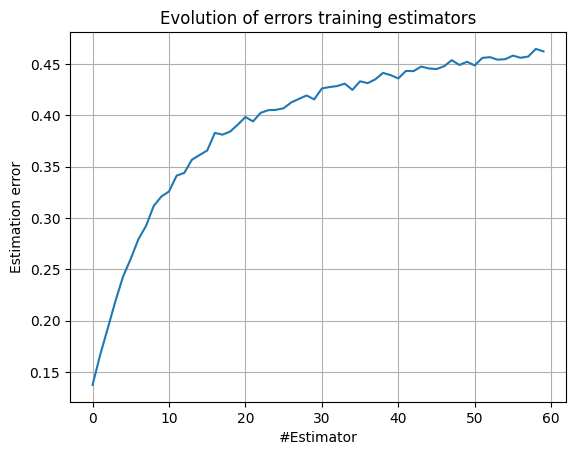

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

## Feature engineering SAMME

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

*Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

In [18]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/RUSBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME_adjacent_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_ar[^-]+$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_ar[^-]+$")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
SAMME Implementation of RUSBoost
	LOS 1: Recall 87.36%
	LOS 2: Recall 29.26%
	LOS 3: Recall 65.32%
	LOS 4: Recall 31.23%
	LOS 5: Recall 28.09%
	LOS 6: Recall 83.83%
LINK 6
SAMME Implementation of RUSBoost
	LOS 1: Recall 89.35%
	LOS 2: Recall 70.61%
	LOS 3: Recall 49.2%
	LOS 4: Recall 12.59%
	LOS 5: Recall 65.4%
	LOS 6: Recall 50.93%
LINK 7
SAMME Implementation of RUSBoost
	LOS 1: Recall 93.8%
	LOS 2: Recall 70.75%
	LOS 3: Recall 56.11%
	LOS 4: Recall 5.8%
	LOS 5: Recall 45.81%
	LOS 6: Recall 55.5%
LINK 8
SAMME Implementation of RUSBoost
	LOS 1: Recall 94.93%
	LOS 2: Recall 70.43%
	LOS 3: Recall 68.53%
	LOS 4: Recall 11.32%
	LOS 5: Recall 55.29%
	LOS 6: Recall 60.94%
LINK 9
SAMME Implementation of RUSBoost
	LOS 1: Recall 91.54%
	LOS 2: Recall 76.04%
	LOS 3: Recall 62.64%
	LOS 4: Recall 25.31%
	LOS 5: Recall 28.29%
	LOS 6: Recall 53.26%
LINK 10
SAMME Implementation of RUSBoost
	LOS 1: Recall 93.25%
	LOS 2: Recall 71.68%
	LOS 3: Recall 43.59%
	LOS 4: Recall 41.53%
	LOS 5: Recall 34

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [17]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/RUSBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME_temp{INPUT_MINUTES_BEFORE}m_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_arr.*", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

USING PREVIOUS 45m INFORMATION
LINK 5
SAMME Implementation of RUSBoost
	LOS 1: Recall 89.51%
	LOS 2: Recall 69.33%
	LOS 3: Recall 35.28%
	LOS 4: Recall 56.28%
	LOS 5: Recall 31.3%
	LOS 6: Recall 71.24%
LINK 6
SAMME Implementation of RUSBoost
	LOS 1: Recall 92.65%
	LOS 2: Recall 51.45%
	LOS 3: Recall 65.07%
	LOS 4: Recall 44.84%
	LOS 5: Recall 25.62%
	LOS 6: Recall 69.19%
LINK 7
SAMME Implementation of RUSBoost
	LOS 1: Recall 93.94%
	LOS 2: Recall 61.48%
	LOS 3: Recall 49.83%
	LOS 4: Recall 55.63%
	LOS 5: Recall 9.57%
	LOS 6: Recall 60.08%
LINK 8
SAMME Implementation of RUSBoost
	LOS 1: Recall 94.37%
	LOS 2: Recall 65.6%
	LOS 3: Recall 48.5%
	LOS 4: Recall 27.25%
	LOS 5: Recall 42.92%
	LOS 6: Recall 59.93%
LINK 9
SAMME Implementation of RUSBoost
	LOS 1: Recall 91.08%
	LOS 2: Recall 79.46%
	LOS 3: Recall 47.91%
	LOS 4: Recall 45.59%
	LOS 5: Recall 60.36%
	LOS 6: Recall 9.07%
LINK 10
SAMME Implementation of RUSBoost
	LOS 1: Recall 93.47%
	LOS 2: Recall 72.3%
	LOS 3: Recall 44.89%
	LOS 4: 

## Feature engineering M2

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

*Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

In [20]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/RUSBoost_{PREDICTED_MINUTES_AHEAD}m_M2_adjacent_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_ar[^-]+$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_ar[^-]+$")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of RUSBoost
	LOS 1: Recall 87.05%
	LOS 2: Recall 72.8%
	LOS 3: Recall 46.02%
	LOS 4: Recall 36.31%
	LOS 5: Recall 45.29%
	LOS 6: Recall 72.0%
LINK 6
M2 Implementation of RUSBoost
	LOS 1: Recall 87.36%
	LOS 2: Recall 72.6%
	LOS 3: Recall 58.84%
	LOS 4: Recall 48.28%
	LOS 5: Recall 50.5%
	LOS 6: Recall 50.12%
LINK 7
M2 Implementation of RUSBoost
	LOS 1: Recall 89.07%
	LOS 2: Recall 74.61%
	LOS 3: Recall 61.75%
	LOS 4: Recall 20.38%
	LOS 5: Recall 38.41%
	LOS 6: Recall 61.78%
LINK 8
M2 Implementation of RUSBoost
	LOS 1: Recall 92.71%
	LOS 2: Recall 73.96%
	LOS 3: Recall 77.77%
	LOS 4: Recall 37.09%
	LOS 5: Recall 34.04%
	LOS 6: Recall 57.82%
LINK 9
M2 Implementation of RUSBoost
	LOS 1: Recall 93.5%
	LOS 2: Recall 77.14%
	LOS 3: Recall 62.29%
	LOS 4: Recall 58.99%
	LOS 5: Recall 45.43%
	LOS 6: Recall 39.94%
LINK 10
M2 Implementation of RUSBoost
	LOS 1: Recall 93.19%
	LOS 2: Recall 72.36%
	LOS 3: Recall 49.24%
	LOS 4: Recall 48.07%
	LOS 5: Recall 41.4%
	LOS 6: Recal

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [21]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/RUSBoost_{PREDICTED_MINUTES_AHEAD}m_M2_temp{INPUT_MINUTES_BEFORE}m_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_arr.*", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

USING PREVIOUS 45m INFORMATION
LINK 5
M2 Implementation of RUSBoost
	LOS 1: Recall 87.22%
	LOS 2: Recall 72.91%
	LOS 3: Recall 45.85%
	LOS 4: Recall 36.32%
	LOS 5: Recall 45.6%
	LOS 6: Recall 72.0%
LINK 6
M2 Implementation of RUSBoost
	LOS 1: Recall 87.41%
	LOS 2: Recall 72.34%
	LOS 3: Recall 59.65%
	LOS 4: Recall 47.66%
	LOS 5: Recall 47.72%
	LOS 6: Recall 54.14%
LINK 7
M2 Implementation of RUSBoost
	LOS 1: Recall 89.17%
	LOS 2: Recall 74.58%
	LOS 3: Recall 61.82%
	LOS 4: Recall 21.12%
	LOS 5: Recall 34.73%
	LOS 6: Recall 61.65%
LINK 8
M2 Implementation of RUSBoost
	LOS 1: Recall 92.66%
	LOS 2: Recall 76.04%
	LOS 3: Recall 75.85%
	LOS 4: Recall 39.92%
	LOS 5: Recall 33.25%
	LOS 6: Recall 57.82%
LINK 9
M2 Implementation of RUSBoost
	LOS 1: Recall 92.15%
	LOS 2: Recall 79.04%
	LOS 3: Recall 62.03%
	LOS 4: Recall 58.51%
	LOS 5: Recall 41.64%
	LOS 6: Recall 35.98%
LINK 10
M2 Implementation of RUSBoost
	LOS 1: Recall 93.15%
	LOS 2: Recall 72.62%
	LOS 3: Recall 49.45%
	LOS 4: Recall 44.04%


# **Modified RUSBoost**

### *Algorithms*

**Algorithm implementation M2**

In [10]:
def labelToIndex(cl,clf):
    return clf.labelDict[cl]

def indexToLabel(i,clf):
    return clf.classes[i]

class ModifiedRUSBoostClassifier_:
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        print("M2 Implementation of MODIFIED RUSBoost")
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []
        self.observation_weights_ = {}

    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, )
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """        
        
        # Class labels mapping to indices
        self.createLabelDict(np.unique(df[y_column]))
        k = len(self.classes)
        # `undersampling_n` elements to sample from each class, equal #samples minority class
        undersampling_n = min(df[y_column].value_counts())

        # Initialize observation weights as 1/(N*(k-1)) where N is total `n_samples` and k is the number of classes
        N = df.shape[0]
        B = N*(k-1)
        D = {epoch: np.full(k-1,1/B) for epoch in df.index}

        # Get whole dataset samples to later calculate the weighting factors on every iteration
        X = df.filter(regex=(X_columns)).values
        y = df[y_column].values
        iTL = np.vectorize(labelToIndex)
        y_indices = iTL(y,self)
        
        # M iterations (#WeakLearners)
        for m in range(self.n_estimators):

        # 1) Random UnderSampling
            df_ = pd.DataFrame()
            for label_ in self.classes:
                _df_label_ = df[ df[y_column]==label_ ]
                if len(_df_label_) <= undersampling_n:
                    df_ = pd.concat([ df_, df[ df[y_column]==label_ ] ])
                else:
                    # Order weights array in decreasing order to select the first `undersampling_n` elements
                    _D_ = {epoch: weight for epoch, weight in D.items() if epoch in _df_label_.index}
                    _D_ = [epoch for epoch,_ in sorted(_D_.items(), key = lambda x: sum(itemgetter(1)(x)), reverse = True)[:undersampling_n]]
                    df_ = pd.concat([ df_, _df_label_.loc[_D_] ])

            
            # Training data initalization
            X_ = df_.filter(regex=(X_columns)).values
            y_ = df_[y_column].values
            D_ = np.sum([D[epoch] for epoch in df_.index], axis=-1)

        # 2) WeakLearner training
            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=D_).predict_proba
            self.models.append(Gm)
        
        # 3) Error-rate computation
            predictions_proba = Gm(X)
            sum_pseudolosses = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        sum_pseudolosses += D[epoch][k_index]*(1-predictions_proba[i,y_indices[i]]+predictions_proba[i,cl])
                        k_index += 1

            error = 0.5 * sum_pseudolosses
            self.estimator_errors_.append(error)
        
        # 4) WeakLearner weight for ensemble computation
            BetaM = error/(1-error)
            self.models[m] = (BetaM,Gm)

        # 5) Observation weights update for next iteration with weights normalization
            norm_ = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        w_ = 0.5*(1+predictions_proba[i,y_indices[i]]-predictions_proba[i,cl])
                        D[epoch][k_index] *= BetaM**(self.learning_rate*w_)
                        norm_ += D[epoch][k_index]
                        k_index += 1
            for epoch in D.keys():
                D[epoch] /= norm_

        self.observation_weights_ = D
        
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i
    
    def predict(self,X):
        sum_model_hypothesis = np.sum(np.stack([-np.log(Bm)*Gm(X) for Bm,Gm in self.models], axis=-1), axis=-1)
        iTL = np.vectorize(indexToLabel)            
        return iTL(np.argmax(sum_model_hypothesis,axis=1),self)

### **NO FEATURE ENGINEERING M2**

In [11]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/ModifiedRUSBoost_{PREDICTED_MINUTES_AHEAD}m_M2_nofeat_link{LINK}.joblib'

    model = ModifiedRUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], "tt_arr$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 96.63%
	LOS 2: Recall 63.9%
	LOS 3: Recall 16.12%
	LOS 4: Recall 7.13%
	LOS 5: Recall 14.34%
	LOS 6: Recall 58.11%
LINK 6
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 19.14%
	LOS 2: Recall 65.5%
	LOS 3: Recall 5.33%
	LOS 4: Recall 78.15%
	LOS 5: Recall 29.86%
	LOS 6: Recall 0.0%
LINK 7
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 94.51%
	LOS 2: Recall 0.0%
	LOS 3: Recall 0.07%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.13%
LINK 8
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 90.66%
	LOS 2: Recall 70.75%
	LOS 3: Recall 83.57%
	LOS 4: Recall 19.79%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 9
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 88.93%
	LOS 2: Recall 0.69%
	LOS 3: Recall 0.0%
	LOS 4: Recall 4.23%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 93.21%
	LOS 2: Recall 73.31%
	LOS 3: Recall 48.1%
	LOS 4: Recall 1.3%
	LOS

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

In [12]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/ModifiedRUSBoost_{PREDICTED_MINUTES_AHEAD}m_M2_adjacent_linkm_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = ModifiedRUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_ar[^-]+$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_ar[^-]+$")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 90.76%
	LOS 2: Recall 0.0%
	LOS 3: Recall 18.13%
	LOS 4: Recall 40.67%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.15%
LINK 6
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 17.82%
	LOS 2: Recall 78.2%
	LOS 3: Recall 0.03%
	LOS 4: Recall 78.64%
	LOS 5: Recall 0.44%
	LOS 6: Recall 0.0%
LINK 7
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 34.79%
	LOS 2: Recall 81.55%
	LOS 3: Recall 61.51%
	LOS 4: Recall 1.85%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 58.74%
	LOS 2: Recall 70.88%
	LOS 3: Recall 83.6%
	LOS 4: Recall 19.75%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 9
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 41.5%
	LOS 2: Recall 13.31%
	LOS 3: Recall 42.54%
	LOS 4: Recall 78.53%
	LOS 5: Recall 11.57%
	LOS 6: Recall 0.57%
LINK 10
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 87.03%
	LOS 2: Recall 1.97%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.95%
	

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [24]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/ModifiedRUSBoost_{PREDICTED_MINUTES_AHEAD}m_M2_temp{INPUT_MINUTES_BEFORE}m_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = ModifiedRUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_arr.*", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

USING PREVIOUS 45m INFORMATION
LINK 5
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 93.74%
	LOS 2: Recall 0.0%
	LOS 3: Recall 51.62%
	LOS 4: Recall 26.17%
	LOS 5: Recall 22.45%
	LOS 6: Recall 0.0%
LINK 6
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 18.88%
	LOS 2: Recall 78.11%
	LOS 3: Recall 0.0%
	LOS 4: Recall 78.64%
	LOS 5: Recall 0.44%
	LOS 6: Recall 0.0%
LINK 7
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 28.75%
	LOS 2: Recall 81.51%
	LOS 3: Recall 1.7%
	LOS 4: Recall 2.62%
	LOS 5: Recall 17.87%
	LOS 6: Recall 0.0%
LINK 8
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 86.35%
	LOS 2: Recall 0.14%
	LOS 3: Recall 8.21%
	LOS 4: Recall 18.56%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 9
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 54.06%
	LOS 2: Recall 5.66%
	LOS 3: Recall 5.03%
	LOS 4: Recall 0.87%
	LOS 5: Recall 93.8%
	LOS 6: Recall 1.13%
LINK 10
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 94.88%
	LOS 2: Recall 0.54%
	LOS 3: Recall

# **LSTM**

Chosen number of LSTM units equal to number of classes to directly obtain number of classes predictions, and attach a same dimensionality Dense layer that combines each class prediction. This can be useful to compensate for possible class imbalance. https://tung2389.github.io/coding-note/unitslstm

### **NO FEATURE ENGINEERING**

**TRAIN or LOAD switch**

In [6]:
train_again = False

In [ ]:
LINK = 5

X_columns="tt_arr.*"
df = training_df[training_df['link_id'] == LINK]
N = df.shape[0]
B = N*(6-1)
D = {epoch: np.full(6-1,1/B) for epoch in df.index}
X = df.filter(regex=(X_columns)).values
X = np.expand_dims(X, axis=2)
X = np.flip(X, 1)
scaler = preprocessing.MinMaxScaler().fit(np.array([[X[:,-1,0].max()]*10, [X[:,-1,0].min()]*10]))

y_column='LOS_dep'
y = df[y_column].values
onehot_encoder = preprocessing.OneHotEncoder().fit(np.expand_dims(y, axis=1))
df_ = pd.DataFrame()
undersampling_n = min(df[y_column].value_counts())
undersampling_n = undersampling_n
for label_ in [1,2,3,4,5,6]:
    tmp = df[ df[y_column]==label_ ].sample(undersampling_n, replace=True)
    if label_ == PRED_LABEL: x_val=np.expand_dims(tmp.filter(regex=(X_columns)).values, axis=2)
    if label_ == 1: x_val_1=np.expand_dims(tmp.filter(regex=(X_columns)).values, axis=2)
    elif label_ == 2: x_val_2=np.expand_dims(tmp.filter(regex=(X_columns)).values, axis=2)
    elif label_ == 3: x_val_3=np.expand_dims(tmp.filter(regex=(X_columns)).values, axis=2)
    elif label_ == 4: x_val_4=np.expand_dims(tmp.filter(regex=(X_columns)).values, axis=2)
    elif label_ == 5: x_val_5=np.expand_dims(tmp.filter(regex=(X_columns)).values, axis=2)
    elif label_ == 6: x_val_6=np.expand_dims(tmp.filter(regex=(X_columns)).values, axis=2)
    df_ = pd.concat([ df_, tmp ])
X_ = df_.filter(regex=(X_columns)).values
X_ = np.expand_dims(X_, axis=2)
X_[:,:,0] = scaler.transform(X_[:,:,0])
X_ = np.flip(X_, 1)
y_ = df_[y_column].values
y_ = onehot_encoder.transform(np.expand_dims(y_, axis=1)).toarray()
D_ = np.sum([D[epoch] for epoch in df_.index], axis=-1)

model = keras.models.Sequential()

model.add(keras.layers.LSTM(
        input_shape=(10, 1),
        units=32,
        return_sequences=False))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(units=6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_, y_, sample_weight=D_, epochs=5, batch_size=32, validation_split=0, verbose=1)

x_val = x_val_1
x_val[:,:,0] = scaler.transform(x_val[:,:,0])
y_pred = list(np.argmax(model.predict(x_val), axis=1)+1)
print(metrics.recall_score([1]*undersampling_n,y_pred, average='micro'))

x_val = x_val_2
x_val[:,:,0] = scaler.transform(x_val[:,:,0])
y_pred = list(np.argmax(model.predict(x_val), axis=1)+1)
print(metrics.recall_score([2]*undersampling_n,y_pred, average='micro'))

x_val = x_val_3
x_val[:,:,0] = scaler.transform(x_val[:,:,0])
y_pred = list(np.argmax(model.predict(x_val), axis=1)+1)
print(metrics.recall_score([3]*undersampling_n,y_pred, average='micro'))

x_val = x_val_4
x_val[:,:,0] = scaler.transform(x_val[:,:,0])
y_pred = list(np.argmax(model.predict(x_val), axis=1)+1)
print(metrics.recall_score([4]*undersampling_n,y_pred, average='micro'))

x_val = x_val_5
x_val[:,:,0] = scaler.transform(x_val[:,:,0])
y_pred = list(np.argmax(model.predict(x_val), axis=1)+1)
print(metrics.recall_score([5]*undersampling_n,y_pred, average='micro'))

x_val = x_val_6
x_val[:,:,0] = scaler.transform(x_val[:,:,0])
y_pred = list(np.argmax(model.predict(x_val), axis=1)+1)
print(metrics.recall_score([6]*undersampling_n,y_pred, average='micro'))

In [7]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    
    X = training_df[training_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values
    #Correctly order the sequence [X(t-N),...,X(t)]
    X = np.flip(X, 1)
    # Min-Max Scaling
    sc = preprocessing.MinMaxScaler().fit(np.array([[X[:,-1].max()]*X.shape[1], [X[:,-1].min()]*X.shape[1]]))
    
    if train_again:
        X = sc.transform(X)
        X = np.expand_dims(X, axis=2)
        y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
        y = np.expand_dims(y, axis=1)
        
        onehot_encoder = preprocessing.OneHotEncoder()
        y = onehot_encoder.fit_transform(y).toarray()

        # build the model
        num_features = X.shape[2]
        num_out = y.shape[1]

        model = keras.models.Sequential()

        model.add(keras.layers.LSTM(
                input_shape=(int(INPUT_MINUTES_BEFORE/5)+1, num_features),
                units=64-num_features,
                return_sequences=False))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(units=num_out, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X, y, epochs=10, batch_size=256, validation_split=0, verbose=0)

        model.save(f'{ROOT}/models/LSTM_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_nofeat_link{LINK}.h5')
    
    else:
        model = keras.models.load_model(f'{ROOT}/models/LSTM_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_nofeat_link{LINK}.h5')
    
    for LOS in range(1,7):
        X_test = sc.transform( validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].filter(regex=("tt_arr.*")).values )
        X_test = np.flip(X_test, 1)
        X_test = np.expand_dims(X_test, axis=2)
        y_pred = model.predict(X_test)
        y_pred = onehot_encoder.inverse_transform(y_pred)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

    del model
    gc.collect()

LINK 5
Size of training data array (1231020, 10, 1)
Size of training labels (1231020, 6)
Epoch 1/10
4809/4809 [==============================] - 33s 5ms/step - loss: 0.4210 - accuracy: 0.8373
Epoch 2/10
4809/4809 [==============================] - 25s 5ms/step - loss: 0.3557 - accuracy: 0.8566
Epoch 3/10
4809/4809 [==============================] - 26s 5ms/step - loss: 0.3451 - accuracy: 0.8605
Epoch 4/10
4809/4809 [==============================] - 25s 5ms/step - loss: 0.3409 - accuracy: 0.8617
Epoch 5/10
4809/4809 [==============================] - 25s 5ms/step - loss: 0.3372 - accuracy: 0.8626
Epoch 6/10
4809/4809 [==============================] - 26s 5ms/step - loss: 0.3337 - accuracy: 0.8630
Epoch 7/10
4809/4809 [==============================] - 25s 5ms/step - loss: 0.3311 - accuracy: 0.8637
Epoch 8/10
4809/4809 [==============================] - 25s 5ms/step - loss: 0.3291 - accuracy: 0.8643
Epoch 9/10
4809/4809 [==============================] - 25s 5ms/step - loss: 0.3275 - a

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

**TRAIN or LOAD switch**

In [19]:
train_again = False

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)

    X = training_df[training_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values
    # Min-Max Scaling per Link
    sc = {}
    sc[LINK] = preprocessing.MinMaxScaler().fit(np.array([[X[:,0].max()]*X.shape[1], [X[:,0].min()]*X.shape[1]]))
    X = sc[LINK].transform(X)
    X = np.expand_dims(X, axis=2)

    for other_link in other_links:
        temp = training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")).values
        sc[other_link] = preprocessing.MinMaxScaler().fit(np.array([[temp[:,0].max()]*temp.shape[1], [temp[:,0].min()]*temp.shape[1]]))
        temp = sc[other_link].transform(temp)
        X = np.concatenate( (X, np.expand_dims(temp, axis=2)) , axis=2)
    #Correctly order the sequence [X(t-N),...,X(t)]
    X = np.flip(X, 1)
        
    if train_again:
        y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
        y = np.expand_dims(y, axis=1)
        
        onehot_encoder = preprocessing.OneHotEncoder()
        y = onehot_encoder.fit_transform(y).toarray()

        # build the model
        num_features = X.shape[2]
        num_out = y.shape[1]

        model = keras.models.Sequential()

        model.add(keras.layers.LSTM(
                input_shape=(int(INPUT_MINUTES_BEFORE/5)+1, num_features),
                units=64-num_features,
                return_sequences=False))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(units=num_out, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X, y, epochs=10, batch_size=256, validation_split=0, verbose=0)

        model.save(f'{ROOT}/models/LSTM_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_adjacent_link{LINK}.h5')
    
    else:
        model = keras.models.load_model(f'{ROOT}/models/LSTM_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_adjacent_link{LINK}.h5')
    
    for LOS in range(1,7):        
        X_test = sc[LINK].transform( validation_df[validation_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values )
        X_test = np.expand_dims(X_test, axis=2)

        for other_link in other_links:
            temp = validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")).values
            temp = sc[other_link].transform(temp)
            X_test = np.concatenate( (X_test, np.expand_dims(temp, axis=2)) , axis=2)
        X_test = np.flip(X_test, 1)
        y_pred = model.predict(X_test)
        y_pred = onehot_encoder.inverse_transform(y_pred)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

    del model
    gc.collect()

### **FEATURE ENGINEERING CLASS BALANCING BY RUS**

https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/
Stochastic Gradient descent increases variance but avoids local minima. A Boosting of high variance LSTM can reduce this variance.

# **LSTM Stacked**

Determine number of hidden units in first LSTM (don't want to sparse the hidden units space much more than the features space)
units = highestPowerof2(num_features+1)

In [ ]:
def highestPowerof2(n):
    for i in range(n, 0, -1):
        if ((i & (i - 1)) == 0): return i;

## **NO FEATURE ENGINEERING**

**TRAIN or LOAD switch**

In [ ]:
train_again = False

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    
    X = training_df[training_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values
    # Min-Max Scaling
    sc = preprocessing.MinMaxScaler().fit(np.array([[X[:,0].max()]*X.shape[1], [X[:,0].min()]*X.shape[1]]))
    
    if train_again:
        X = sc.transform(X)
        X = np.expand_dims(X, axis=2)
        print(f'Size of training data array {X.shape}')
        y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
        y = np.expand_dims(y, axis=1)
        
        onehot_encoder = preprocessing.OneHotEncoder()
        y = onehot_encoder.fit_transform(y).toarray()
        print(f'Size of training labels {y.shape}')

        # build the model
        num_features = X.shape[2]
        num_out = y.shape[1]

        model = keras.models.Sequential()

        model.add(keras.layers.LSTM(
                input_shape=(int(INPUT_MINUTES_BEFORE/5)+1, num_features),
                units=highestPowerof2(num_features+1),
                return_sequences=True))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.LSTM(
                units=num_out,
                return_sequences=False))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(units=num_out, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X, y, epochs=10, batch_size=500, validation_split=0, verbose=0)

        model.save(f'{ROOT}/models/LSTM_Stacked_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_nofeat_link{LINK}.h5')
    
    else:
        model = keras.models.load_model(f'{ROOT}/models/LSTM_Stacked_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_nofeat_link{LINK}.h5')
    
    for LOS in range(1,7):
        X_test = sc.transform( validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].filter(regex=("tt_arr.*")).values )
        X_test = np.expand_dims(X_test, axis=2)
        y_pred = model.predict(X_test)
        y_pred = onehot_encoder.inverse_transform(y_pred)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

    del model
    gc.collect()

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

**TRAIN or LOAD switch**

In [ ]:
train_again = False

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)

    X = training_df[training_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values
    # Min-Max Scaling per Link
    sc = {}
    sc[LINK] = preprocessing.MinMaxScaler().fit(np.array([[X[:,0].max()]*X.shape[1], [X[:,0].min()]*X.shape[1]]))
    X = sc[LINK].transform(X)
    X = np.expand_dims(X, axis=2)

    for other_link in other_links:
        temp = training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")).values
        sc[other_link] = preprocessing.MinMaxScaler().fit(np.array([[temp[:,0].max()]*temp.shape[1], [temp[:,0].min()]*temp.shape[1]]))
        temp = sc[other_link].transform(temp)
        X = np.concatenate( (X, np.expand_dims(temp, axis=2)) , axis=2)
        
    if train_again:
        print(f'Size of training data array {X.shape}')
        y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
        y = np.expand_dims(y, axis=1)
        
        onehot_encoder = preprocessing.OneHotEncoder()
        y = onehot_encoder.fit_transform(y).toarray()
        print(f'Size of training labels {y.shape}')

        # build the model
        num_features = X.shape[2]
        num_out = y.shape[1]

        model = keras.models.Sequential()
        
        model.add(keras.layers.LSTM(
                input_shape=(int(INPUT_MINUTES_BEFORE/5)+1, num_features),
                units=highestPowerof2(num_features+1),
                return_sequences=True))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.LSTM(
                units=num_out,
                return_sequences=False))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(units=num_out, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X, y, epochs=10, batch_size=500, validation_split=0, verbose=1)

        model.save(f'{ROOT}/models/LSTM_Stacked_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_adjacent_link{LINK}.h5')
    
    else:
        model = keras.models.load_model(f'{ROOT}/models/LSTM_Stacked_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_adjacent_link{LINK}.h5')
    
    for LOS in range(1,7):        
        X_test = sc[LINK].transform( validation_df[validation_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values )
        X_test = np.expand_dims(X_test, axis=2)

        for other_link in other_links:
            temp = validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")).values
            temp = sc[other_link].transform(temp)
            X_test = np.concatenate( (X_test, np.expand_dims(temp, axis=2)) , axis=2)
        y_pred = model.predict(X_test)
        y_pred = onehot_encoder.inverse_transform(y_pred)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

    del model
    gc.collect()

# **LSTM RUSBoost**

### *Algorithms*

**Algorithm implementation M2**

In [5]:
def labelToIndex(cl,clf):
    return clf.labelDict[cl]

def indexToLabel(i,clf):
    return clf.classes[i]

class LSTMRUSBoostClassifier_:
    
    def __init__(self, sequence_length: int, n_lstm=50, learning_rate=1.0):
        """
        param sequence_length: Length of each feature sequence. sequence_length = N in the feature sample [x(t),...,x(t-N)]
        """
        print("M2 Implementation of LSTM RUSBoost")
        self.n_lstm = n_lstm
        self.learning_rate = learning_rate
        self.models = []
        self.scaler = []
        self.onehot_encoder = preprocessing.OneHotEncoder
        self.sequence_length = sequence_length
        self.estimator_errors_ = []
        self.observation_weights_ = {}

    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, ). Sample sequence order is expected to be received as [x(t),...,x(t-N)]
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """        
        
        # Class labels mapping to internal indices ('lab1'->0, 'lab2'->1,...'labN'->N)
        self.createLabelDict(np.unique(df[y_column]))
        # `undersampling_n` elements to sample from each class, equal #samples minority class
        undersampling_n = min(df[y_column].value_counts())

        # Initialize observation weights as 1/(N*(k-1)) where N is total `n_samples` and k is the number of classes
        N = df.shape[0]
        k = len(self.classes)
        B = N*(k-1)
        D = {epoch: np.full(k-1,1/B) for epoch in df.index}

        # Get whole dataset samples to later calculate the weighting factors on every iteration
        X = df.filter(regex=(X_columns)).values
        if X.shape[1] == self.sequence_length:
            X = np.expand_dims(X, axis=2)
        elif X.shape[1] % self.sequence_length == 0:
            X = X.reshape((X.shape[0],self.sequence_length,int(X.shape[0]/self.sequence_length)), order='F')
        else:
            print("The length of all feature sequences must be the same")
        #Correctly order the sequence [X(t-N),...,X(t)]
        X = np.flip(X, 1)

        # Initialize input scaler for each feature
        for feature in range(X.shape[2]):
            self.scaler.append( preprocessing.MinMaxScaler().fit(np.array([[X[:,-1,feature].max()]*self.sequence_length, [X[:,-1,feature].min()]*self.sequence_length])) )
            X[:,:,feature] = self.scaler[feature].transform(X[:,:,feature])
        
        # Initialize output one-hot vector encoder
        y = df[y_column].values
        iTL = np.vectorize(labelToIndex)
        y_indices = iTL(y,self)
        self.onehot_encoder = self.onehot_encoder().fit(np.expand_dims(y, axis=1))
        
        # M iterations (#WeakLearners)
        for m in range(self.n_lstm):

        # 1) Random UnderSampling
            df_ = pd.DataFrame()
            for label_ in self.classes:
                df_ = pd.concat([ df_, df[ df[y_column]==label_ ].sample(undersampling_n, replace=False) ])
            
            # Training data initalization
            X_ = df_.filter(regex=(X_columns)).values
            if X_.shape[1] == self.sequence_length:
                X_ = np.expand_dims(X_, axis=2)
            elif X_.shape[1] % self.sequence_length == 0:
                X_ = X_.reshape((X_.shape[0],self.sequence_length,int(X_.shape[0]/self.sequence_length)), order='F')
            # Scale inputs
            for feature in range(X_.shape[2]):
                X_[:,:,feature] = self.scaler[feature].transform(X_[:,:,feature])
            #Correctly order the sequence [X(t-N),...,X(t)]
            X_ = np.flip(X_, 1)

            y_ = df_[y_column].values
            y_ = self.onehot_encoder.transform(np.expand_dims(y_, axis=1)).toarray()
            D_ = np.sum([D[epoch] for epoch in df_.index], axis=-1)

        # 2) LSTM training
            num_features = X_.shape[2]
            num_out = y_.shape[1]

            model = keras.models.Sequential()

            model.add(keras.layers.LSTM(
                    input_shape=(self.sequence_length, num_features),
                    units=32,
                    return_sequences=False))
            model.add(keras.layers.Dropout(0.2))

            model.add(keras.layers.Dense(units=num_out, activation='softmax'))

            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            model.fit(X_, y_, sample_weight=D_, epochs=5, batch_size=32, validation_split=0, verbose=0)
        
        # 3) Error-rate computation
            predictions_proba = model.predict(X,verbose=None)
            sum_pseudolosses = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        sum_pseudolosses += D[epoch][k_index]*(1-predictions_proba[i,y_indices[i]]+predictions_proba[i,cl])
                        k_index += 1

            error = 0.5 * sum_pseudolosses
            self.estimator_errors_.append(error)
        
        # 4) WeakLearner weight for ensemble computation
            BetaM = error/(1-error)
            self.models.append( (BetaM,model.predict) )

        # 5) Observation weights update for next iteration with weights normalization
            norm_ = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        w_ = 0.5*(1+predictions_proba[i,y_indices[i]]-predictions_proba[i,cl])
                        D[epoch][k_index] *= BetaM**(self.learning_rate*w_)
                        norm_ += D[epoch][k_index]
                        k_index += 1
            for epoch in D.keys():
                D[epoch] /= norm_

        self.observation_weights_ = D
        
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i
    
    def predict(self,X):
        if X.shape[1] == self.sequence_length:
            X = np.expand_dims(X, axis=2)
        elif X.shape[1] % self.sequence_length == 0:
            X = X.reshape((X.shape[0],self.sequence_length,int(X.shape[0]/self.sequence_length)), order='F')
        else:
            print("The length of all feature sequences must be the same")
        
        # Scale inputs
        for feature in range(X.shape[2]):
            X[:,:,feature] = self.scaler[feature].transform(X[:,:,feature])
        
        sum_model_hypothesis = np.sum(np.stack([-np.log(Bm)*Gm(X,verbose=None) for Bm,Gm in self.models], axis=-1), axis=-1)
        return self.onehot_encoder.inverse_transform(sum_model_hypothesis)

### **NO FEATURE ENGINEERING M2**

In [6]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    
    filename = f'{ROOT}/models/LSTM-RUSBoost_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_M2_nofeat_link{LINK}.joblib'

    model = LSTMRUSBoostClassifier_(sequence_length=int(INPUT_MINUTES_BEFORE/5)+1, n_lstm=30, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], "tt_arr.*", 'LOS_dep')
    #joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of LSTM RUSBoost
	LOS 1: Recall 86.89%
	LOS 2: Recall 54.01%
	LOS 3: Recall 28.22%
	LOS 4: Recall 31.31%
	LOS 5: Recall 24.29%
	LOS 6: Recall 49.63%
LINK 6
M2 Implementation of LSTM RUSBoost
	LOS 1: Recall 98.6%
	LOS 2: Recall 3.19%
	LOS 3: Recall 7.6%
	LOS 4: Recall 4.55%
	LOS 5: Recall 14.95%
	LOS 6: Recall 75.55%
LINK 7
M2 Implementation of LSTM RUSBoost
	LOS 1: Recall 98.49%
	LOS 2: Recall 0.0%
	LOS 3: Recall 10.71%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 83.38%
LINK 8
M2 Implementation of LSTM RUSBoost
	LOS 1: Recall 97.71%
	LOS 2: Recall 28.8%
	LOS 3: Recall 76.41%
	LOS 4: Recall 0.36%
	LOS 5: Recall 11.25%
	LOS 6: Recall 52.77%
LINK 9
M2 Implementation of LSTM RUSBoost
	LOS 1: Recall 92.41%
	LOS 2: Recall 0.0%
	LOS 3: Recall 0.0%
	LOS 4: Recall 36.82%
	LOS 5: Recall 0.0%
	LOS 6: Recall 45.89%
LINK 10
M2 Implementation of LSTM RUSBoost
	LOS 1: Recall 95.43%
	LOS 2: Recall 42.45%
	LOS 3: Recall 21.19%
	LOS 4: Recall 5.6%
	LOS 5: Recall 10.18

# **CLEAN UP**

In [ ]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git pull

## COMMIT AND REMOVE

In [ ]:
%cd /content/Traffic
!sh /content/drive/MyDrive/Traffic/scripts/logout.sh

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/Traffic